# Computer Vision

Perception largely takes place outside of our consciousness, within specialized visual, auditory, and other sensory modules in our brains. By the time sensory information reaches our consciousness, it is already adorned with high-level features. For example, when we look at a picture of a cute puppy, we cannot choose not to see the puppy, not to notice its cuteness. Nor can we explain how we recognize a cute puppy; it’s just obvious to us. Thus, we cannot trust our subjective experience: perception is not trivial at all, and to understand it we must look at how our sensory modules work.

Convolutional Neural networks (CNNs) emerged from the study of the **brain’s visual cortex**. [David H. Hubel and Torsten Wiesel](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1363130/pdf/jphysiol01298-0128.pdf) performed a series of experiments on cats and monkeys in the '50s, giving crucial insights into the structure of the visual cortex. In particular, they showed that many neurons in the visual cortex have a small local receptive field, meaning they react only to visual stimuli located in a limited region of the visual field. The receptive fields of different neurons may overlap, and together they tile the whole visual field. Moreover, they showed that some neurons react only to images of horizontal lines, while others react only to lines with different orientations (two neurons may have the same receptive field but react to different line orientations). They also noticed that some neurons have larger receptive fields, and they react to more complex patterns that are combinations of the lower-level patterns. These observations led to the idea that the higher-level neurons are based on the outputs of neighboring lower-level neurons. 

![](./images/visual-cortex.png)

This powerful architecture is able to detect all sorts of complex patterns in any area of the visual field and these studies inspired the **neocognitron**, introduced in 1980, which gradually evolved into what we now call [**Convolutional Neural Networks (CNN)**](https://ieeexplore.ieee.org/document/726791), that has some building blocks that we already know, such as fully connected layers and sigmoid activation functions, but it introduces two new building blocks: **convolutional layers** and **pooling layers**.

Why not simply use a fully connected deep neural network for image recognition tasks? Although this works fine for small images (e.g.,MNIST), what happens when the images get more complex? It breaks down for larger images because of the huge number of parameters it requires. For example, a 100x100–pixel image has 10.000 pixels, and if the first layer has just 1.000 neurons, this means a total of 10 million connections. And that’s just the first layer. CNNs solve this problem using **partially connected layers** and **weight sharing**.

## Convolution

A convolution filter is a small matrix (also known as a **kernel**) used to apply effects like blurring, sharpening, edge detection, and more to an image. The kernel is usually smaller than the image itself and slides (convolves) over the image, applying a mathematical operation to each pixel and its neighbors. Consider an image from the Fashion MNIST dataset, we can define a simple filter where we multiply each pixel of the image by the respective filter value. We do the same for each pixel, and we sum up the values. This will become the new value for the current pixel:

![](images/convolution.png)

The mathematical representation of the convolution operation G of an image I with a kerner of size $(f_w,f_h)$ for a pixel $(x,y)$ is given by:

$\displaystyle G(x, y) = \sum_{i=-f_h/2}^{f_h/2} \sum_{j=-f_w/2}^{f_w/2} K(i, j) \cdot I(x - i, y - j)$

When the kernel overlaps the boundary of the image, several techniques can be used to handle the boundaries: **zero-padding** (extend the image with zeros), **replication** (extend the image by replicating the edge values) or **reflecting** (extend the image by reflecting the image). This is  a common tool used in image processing. Changing the values of the filter, we can apply different effects to the image. For example, we can use a filter to detect vertical lines, another to detect horizontal lines, and so on. We can try this on the 8-bit 512 x 512 grayscale image available on the [SciPy library](https://scipy.org/) for easy use in demos:

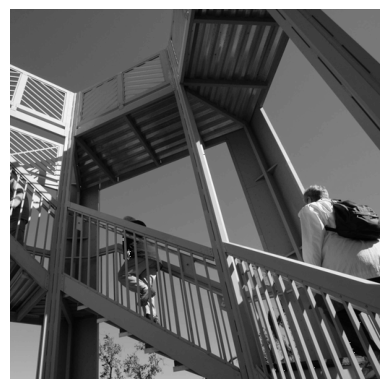

In [1]:
import matplotlib.pyplot as plt
from scipy import datasets

image = datasets.ascent()

plt.grid(False)
plt.gray()
plt.axis('off')
plt.imshow(image)
plt.show()

We can create a filter as a 3x3 array:

In [2]:
import numpy as np

kernel = np.array([[-1, 0, 1], 
                   [-2, 0, 2], 
                   [-1, 0, 1]])

To do the convolution, we iterate over the image, leaving a one pixel margin, and multiply out each of the neighbors of the current pixel by the value defined in the filter. We'll then ensure the result is in the range 0-255. Finally we'll load the new value into the transformed image.

In [3]:
def convolution(image, kernel):
    image_height, image_width = image.shape
    output_image = np.zeros((image_height, image_width))
    
    kernel_height, kernel_width = kernel.shape
    delta_height = kernel_height // 2
    delta_width = kernel_width // 2

    for i in range(delta_height, image_height - delta_height):
        for j in range(delta_width, image_width - delta_width):
            region = image[i-delta_height:i+delta_height+1, j-delta_width:j+delta_width+1]
            output_pixel = np.sum(region * kernel)
            output_pixel = max(0, min(output_pixel, 255))
            output_image[i, j] = output_pixel

    return output_image

In [4]:
image_transformed = convolution(image, kernel)

Now we can plot the image to see the effect of the convolution:

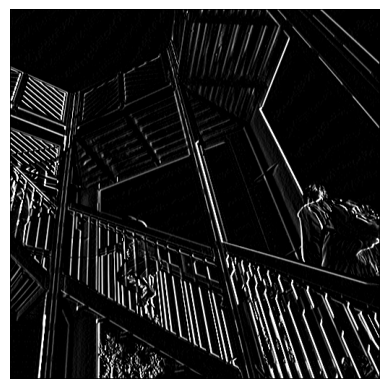

In [5]:
plt.gray()
plt.grid(False)
plt.imshow(image_transformed)
plt.axis('off')
plt.show() 

We can see that the filter has detected the vertical lines in the image, we can also try other filters to detect horizontal lines, edges, and more. This is the basic idea behind convolutional neural networks. We can use filters to detect different patterns in the image.

In the case of RGB images with 3 channels (corresponding to red, green, blue), we have 3 channels (depth) one corresponding to each of the RGB in the image. So here we are accounting convolution operation for all three channels separately? Are we sliding filter along the depth too? No, we use the filter of the same depth as the input and place the filter over the input and compute the weighted sum across all 3 dimensions.

![](images/rgb-convolution.png)


This is just a single convolution. Typically, we apply multiple convolutions to extract more complex features, such as faces or hands, rather than just simple vertical or horizontal lines. Let's consider a scenario in which we have a picture, and we don't know its content. We have a set of kernels that can be applied to the image to extract specific features. For example, some kernl can detect two vertical shapes resembling human legs, while others can identify features like hands. Another kernel can extract a roughly circular shape, representing a face. However, an untrained network lacks the context to understand these shapes; it only knows that a filter can highlight certain patterns. Finally, an algorithm can match these extracted features. By learning from labeled images, it can determine if the presence of these features indicates a human in the picture. If all the specified features (legs, hands, and face) are present, the algorithm can label the image as containing a human:

![](images/human.png)

So, our model can now not only learn weights and biases but also **learn kernels**. By learning sets of kernels that can detect specific features, such as those indicative of a human, we can develop a **computer vision model** capable of handling sophisticated images and predicting their content accurately. This ability to learn and recognize complex patterns enables the model to perform advanced image analysis and classification tasks effectively. In the example, we use features like legs, hands, and faces (attributes we, as humans, use to identify "humans") to demonstrate the concept. However, the algorithm might detect patterns in the image that are **meaningless to us**. There may be consistent pixel patterns in labeled images that the algorithm learns to exploit.

The basic structure of a Convolutional Neural Network (CNN) consists of a set of **convolution layers**. Neurons in the first layer are not connected to every single pixel in the input image but only to pixels within their **receptive fields**. Similarly, each neuron in the second convolutional layer is connected only to neurons located within a small rectangle in the first layer. This architecture enables the network to focus on small, low level features in the first hidden layer, which are then assembled into larger, higher level features in subsequent hidden layers. This **hierarchical approach** allows the network to learn increasingly complex representations of the input data (just like the human visual cortex):

![](images/convolution-layers.png)

More precisely, a neuron located in position $(i,j)$ of a given layer is connected to the outputs of the neurons in the previous layer located at rows $(i - f_h/2)$ to $(i + f_h/2)$ and columns $(j - f_w/2)$ to $(j + f_w/2)$, where $f_h$ and $f_w$ are the height and width of the receptive field. 

In order for a layer to have the same height and width as the previous layer, it is common to add some frame around the orginal image (**padding**), typically filled with zero. Moreover, it is possible to connect a large input layer to a much smaller layer by spacing out the receptive fields. This reduces the computational complexity. The shift $(s_w, s_h)$ from one receptive field to the next is called the **stride**.

![](images/padding-stride.png)

A layer full of neurons using the same kernel outputs a **feature map**, which highlights the areas in an image that activate the kernel the most. Moreover, a convolutional layer typically has **multiple kernels** and outputs one feature map per kernel, so it is more accurately represented in 3D. It has one neuron per pixel in each feature map, and all neurons within a given feature map share the same parameters. Neurons in different feature maps use different parameters. In short, a convolutional layer simultaneously applies multiple trainable kernels to its inputs, making it capable of detecting multiple features anywhere in its inputs:

![](images/multiple-convolutional-layers.png)

Mathematically, the output $z$ of the neuron located in $(i,j)$ for a of a feature map $k$ is given by:

$\displaystyle z_{i,j,k} = b_k + \sum_{u=-f_h/2}^{f_h/2} \sum_{v=-f_w/2}^{f_w/2} \sum_{q=0}^{n} x_{i*s_h+u, j*s_w+v, q} \cdot w_{u,v,q,k}$

where $x$ is the output of the previous layer, $w_{u,v,q,k}$ is the connection weight of the feature map $q$ of the previous layer and the feature map $k$ of the current layer, $b_k$ is the bias term of the feature map $k$, and $n$ is the number of feature maps in the previous layer.

Notice that the fact that all neurons in a feature map share the same kernel dramatically reduces the number of parameters in the model. Once the CNN has learned to recognize a pattern in one location, it can recognize it in any other location. In contrast, once a fully connected neural network has learned to recognize a pattern in one location, it can only recognize it in that particular location.

Let's see how we can implement a convolutional layer in Keras. First, we load and preprocess a couple of sample images:

In [6]:
from sklearn.datasets import load_sample_images
import tensorflow as tf

images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

Look at the shape of the images tensor:

In [7]:
images.shape

TensorShape([2, 70, 120, 3])

It is a 4D tensor: there are two sample images (first dimension), each image is 70×120 (second and third dimensions) and each pixel holds one value per color channel (last dimension). Now we create a 2D convolutional layer with 32 kernels, each of size 7×7 and we feed it these images. Notice that "2D" refers to the number of spatial dimensions (height and width), but the layer takes 4D inputs (batch size and the channels).

In [8]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
feature_maps = conv_layer(images)

Look at the output’s shape:

In [9]:
feature_maps.shape

TensorShape([2, 64, 114, 32])

There are 32 channels instead of 3, because we have 32 kernels, so we get 32 output feature maps. So instead of the intensity of red, green, and blue at each location, we now have the intensity of each feature at each location. The height and width have both shrunk by 6 pixels. This is due to the fact that the Conv2D layer does not use any zeropadding by default, which means that we lose a few pixels on the sides of the output feature maps, depending on the size of the filters. If instead we set padding="same", then the inputs are padded with enough zeros on all sides to ensure that the output feature maps end up with the same size as the inputs:

In [10]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same")
feature_maps = conv_layer(images)
feature_maps.shape

TensorShape([2, 70, 120, 32])

Moreover, if we set also the stride greater than one, then the output size will not be equal to the input size (even if padding="same"):

In [11]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same", strides=(2,2))
feature_maps = conv_layer(images)
feature_maps.shape

TensorShape([2, 35, 60, 32])

We can show in 1D picture the effects of padding and stride values, in order to understand better the final output size:

![](images/padding-stride-options.png)


Just like dense layer, a convolutional layer holds all the weights, including kernels and biases. The kernels are initialized randomly, while the biases are initialized to zero:

In [12]:
weights, biases = conv_layer.get_weights()

print("weights shape: ", weights.shape)
print("biases shape: ", biases.shape)

weights shape:  (7, 7, 3, 32)
biases shape:  (32,)


The weights shape is the kernel height, the kernel width, the number of input channels and the number of output channels (number of kernels). Notice that the height and width of the input image do not appear in the weights shape, this is because all the neurons in the output feature maps share the same weights, as explained earlier. This means that we can feed images of any size to a convolutional layer, as long as they are at least as
large as the kernels, and if they have the right number of channels (three in this case).

Lastly, as in dense layers, we will generally specify an activation function and a weights initializer: a convolutional layer performs a linear operation, so if we stack multiple convolutional layers without any activation functions they would all be equivalent to a single convolutional layer, and they wouldn’t be able to learn anything really complex.

As we can see, convolutional layers have several hyperparameters (number of kernels, kernel size, padding, strides, activation, initializer). As usual, we can use cross-validation to find the right hyperparameter values, but this is very time-consuming.

A big challenge with convolutional layers is that they require a huge amount of working memory, especially during training. The reverse pass of backpropagation requires all the intermediate values computed during the forward pass. For example, consider a convolutional layer with 200 5×5 kernels, with stride 1 and padding. If the input is a 150×100 RGB image, then the number of parameters is (5×5×3+1)×200 = 15.200, which is fairly small compared to a fully connected layer. However, each of the 200 feature maps contains 150×100 neurons, and each of these neurons needs to compute a weighted sum of its 5×5×3 inputs: that’s a total of 225 million float multiplications. Not as bad as a fully connected layer, but still quite computationally intensive Moreover, if the feature maps are represented using 32-bit floating points, then the convolutional layer output will occupy 12 MB of memory just for one
instance. If the training batch contains 100 instances, then the layer will occupy up to 1.2 GB of memory. During inference the memory occupied by one layer can be released as soon as the next layer has been computed, so we only need as much memory as required by two consecutive layers. But during training everything computed during the forward pass needs to be preserved for the reverse pass, so the amount of memory needed is  at least the total amount of memory required by all layers.

## Pooling

The idea is to subsample (shrink) the input image in order to reduce the computational load, the memory usage, and the number of parameters, while maintaining the features that are important. Just like to convolution, each neuron in a pooling layer is connected to the outputs of a limited number of neurons in the previous layer, located within a small rectangular receptive field. We iterate over the image, look at each pixel and it's immediate neighbors and take a value (maximum, average) from them and load it into the new image. The new image size is reduced becouse each pooling window don't overlap with the previous one:

![](images/pooling.png)

Mathematically the pooling P of an image I with a pooling windows of size p is give by:

$\displaystyle P(x, y) = f_{i,j=0...p-1} I(x \cdot p + i, y \cdot p + j)$

where f is the pooling function. Tipically, the pooling function is the maximum value of the pixels in the pooling window (**max pooling**) or the average value of the pixels in the pooling window (**average pooling**). When we apply this process to an image following a filter, it enhances the features we've extracted while compressing the data without sacrificing crucial information. For instance, in an image where vertical lines have been extracted through filtering, pooling accentuates these lines even more, effectively reducing the size of the image:

In [13]:
def max_pooling(image, pool_size=(2, 2)):
    image_height, image_width = image.shape
    pool_height, pool_width = pool_size

    output_height = image_height // pool_height
    output_width = image_width // pool_width

    output_image = np.zeros((output_height, output_width))

    for i in range(output_height):
        for j in range(output_width):
            window = image[i*pool_height:i*pool_height+pool_height, j*pool_width:j*pool_width+pool_width]
            output_image[i, j] = np.max(window)

    return output_image

In [14]:
image_pooled = max_pooling(image_transformed, pool_size=(4, 4))

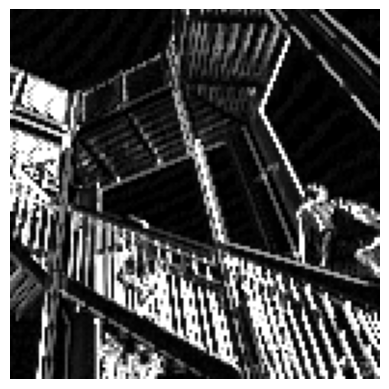

In [15]:
plt.gray()
plt.grid(False)
plt.imshow(image_pooled)
plt.axis('off')
plt.show() 

We can see the reduction in size of the image after applying the pooling:

In [16]:
print("image_transformed shape: ", image_transformed.shape)
print("image_pooled shape: ", image_pooled.shape)

image_transformed shape:  (512, 512)
image_pooled shape:  (128, 128)


Generally max polling perform better then average pooling. This may seem surprising, since computing the mean generally loses less information than computing the max. But on the other hand, max pooling preserves only the strongest features, getting rid of all the meaningless ones, so the next layers
get a cleaner signal to work with. 

Just like in convolutional neurons, we define size, stride, and padding type. However, a pooling neuron **has no weights**; all it does is aggregate the inputs using an aggregation function (such as the max or mean). This **reduce computations, memory usage, and the number of parameters**. However, it has a downside: it’s very destructive. Even with a tiny 2×2 kernel and a stride of 2, the output will be two times smaller in both directions (so its area will be four times smaller), simply dropping 75% of the input values. 

We can create a pooling layer using Keras:

In [17]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)
avg_pool = tf.keras.layers.AvgPool2D(pool_size=2)

The pooling can be performed along the **depth dimension** instead of the **spatial dimensions**. This allow to learn to be invariant to various
features, such as the rotation or location of an object in the image:

![](images/depthwise-pooling.png)

One last type of pooling is the **global average pooling layer**. It computes the mean of each entire feature map, like an average pooling layer with a kernel with the same spatial dimensions as the inputs). This means that it just outputs a single number per feature map and per instance. Although this is extremely destructive (most of the information in the feature map is lost), it can be useful just before the output layer. For example, if we apply this layer to the input images, we get the mean intensity of red, green, and blue for each image:

In [18]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()
print("Average RGB intensity: ", global_avg_pool(images))


Average RGB intensity:  tf.Tensor(
[[0.64338624 0.5971759  0.5824972 ]
 [0.76306933 0.2601113  0.10849128]], shape=(2, 3), dtype=float32)


## CNN Architectures

Convolutional Neural Networks are are a special kind of multi-layer neural networks. Like almost every other neural networks they are trained with a version of the back-propagation algorithm. Where they differ is in the architecture. Convolutional Neural Networks are designed to recognize visual patterns directly from pixel images with minimal preprocessing.  They can recognize patterns with extreme variability (such as handwritten characters), and with robustness to distortions and simple geometric transformations.

Typical CNN architectures stack a few convolutional layers (each one generally followed by a ReLU activation function), then a pooling layer, then another few convolutional layers (plus ReLU), then another pooling layer, and so on. The image gets **smaller and smaller** as it progresses through the network, but it also typically gets **deeper and deeper** (with more feature maps). At the top of the stack, a regular feedforward neural network is added, composed of a few fully connected layers (plus ReLUs), and the final layer outputs the prediction (a softmax layer that outputs estimated class probabilities):

![](images/cnn-architecture.png)

For this example, we can use a basic CNN with the fashion MNIST dataset, which is a little bit more sophisticated than the handwriting digits and it makes it harder to get a higher level of accuracy:

In [19]:
fashion = tf.keras.datasets.fashion_mnist

(training_images, training_labels), (test_images, test_labels) = fashion.load_data()
training_images = training_images / 255.0
test_images = test_images / 255.0

(training_images, validation_images) = training_images[5000:], training_images[:5000] 
(training_labels, validation_labels) = training_labels[5000:], training_labels[:5000]

We repeat the same structure twice: a convolutional layer followed by a max pooling layer. For larger images, we could repeat this structure several more times. The number of repetitions is a hyperparameter we can tune. Notice that the number of kernel doubles as we climb up toward the output layer: it makes sense for it to grow, since the number of low-level features is often fairly low (e.g., small circles, horizontal lines), but there are many different ways to combine them into higher-level features. It is a common practice to double the number of kernels after each pooling layer. Since the pooling layer divides each spatial dimension by a factor of 2, we can afford to double the number of feature maps in the next layer without fear of exploding the number of parameters, memory usage, or computational load. Next we add the fully connected network, composed of a hidden dense layer and a dense output layer. Notice that we must flatten the inputs just before the first dense layer, since it expects a 1D array of features for each instance. We also add a dropout layers to reduce overfitting:

In [20]:
basic_model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='conv1'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pooling1'),
  tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', name='conv2'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2), name='pooling2'),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=20, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(units=10, activation='softmax')
], name='basic_model')

In [21]:
basic_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

We can check the number of parameters in the model:

In [22]:
print('Trainable params:', basic_model.count_params())

Trainable params: 138726


Since trainig can be really time consuming, we can save the model and the history of the training to load them in future openings of the notebook. We can also use the [TensorBoard](https://www.tensorflow.org/tensorboard) tool to visualize the process:

In [23]:
%load_ext tensorboard

You can see the progress of the training in the TensorBoard interface by running the following command in a terminal:

```bash
tensorboard --logdir=./my_logs --port=6006
```

Then open your web browser and go to http://localhost:6006/. You can see the training loss and accuracy, as well as the validation loss and accuracy. You can also see the graph of the model, the learning curves, and more.

In [24]:
import pandas as pd
import os, datetime

epochs = 10

# if the model exists, we can load it, otherwise we start training from scratch:
exists = os.path.exists("models/basic_model.keras")

if(not exists):
    logdir = os.path.join("models/logs/basic_model")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    result = basic_model.fit(training_images, training_labels, verbose=0, epochs=epochs,
                             validation_data=(validation_images, validation_labels),
                             callbacks=[tensorboard_callback])
    basic_model_history = result.history
    np.save('models/basic_model', basic_model_history)
    basic_model.save('models/basic_model.keras')
else:
    basic_model = tf.keras.models.load_model("models/basic_model.keras")   
    basic_model_history = np.load('models/basic_model.npy', allow_pickle='TRUE').item()   


We can check the model accuracy at the end of the training on the validation set and on the test set:

In [25]:
print("Validation accuracy:", '{:.2f}'.format(basic_model_history["val_accuracy"][-1]))

Validation accuracy: 0.90


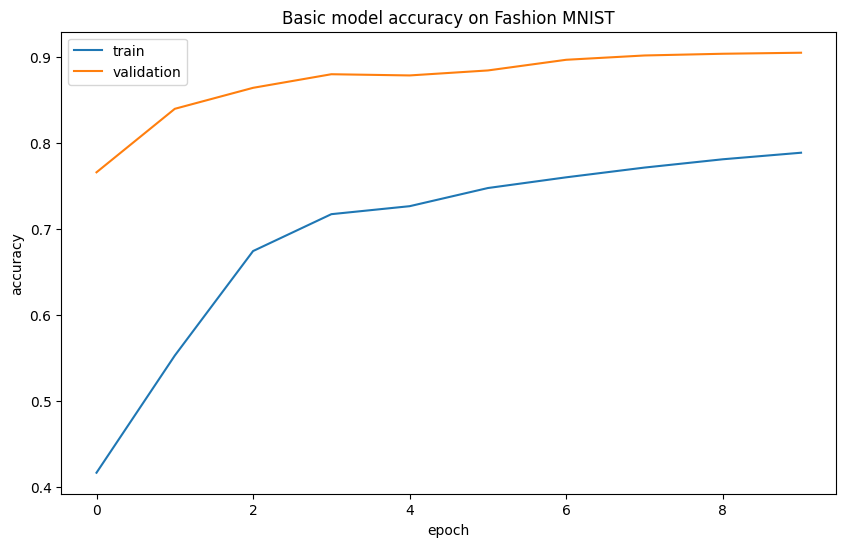

In [26]:
plt.figure(figsize=(10,6))

plt.plot(np.arange(epochs), basic_model_history['accuracy'])
plt.plot(np.arange(epochs), basic_model_history['val_accuracy'])
plt.title('Basic model accuracy on Fashion MNIST')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [27]:
loss, accuracy = basic_model.evaluate(test_images, test_labels, verbose=0)
print("Basic model test accuracy:", '{:.2f}'.format(accuracy))

Basic model test accuracy: 0.89


We can show the convolutions results graphically. We can select a few images of the same class from the test set and plot their feature maps after the first convolutional layer:

In [28]:
print(test_labels[:100])

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 3 9 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2]


We get some images with the same label, for example "shoes":

In [29]:
first_image =  0
second_image = 23
third_image = 28

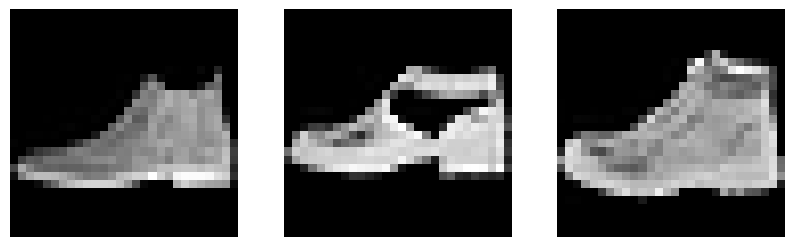

In [30]:
fig = plt.figure(figsize=(10, 8))

fig.add_subplot(1, 3, 1)
plt.imshow(test_images[first_image].reshape(28,28))
plt.axis('off')

fig.add_subplot(1, 3, 2)
plt.imshow(test_images[second_image].reshape(28,28))
plt.axis('off')

fig.add_subplot(1, 3, 3)
plt.imshow(test_images[third_image].reshape(28,28))
plt.axis('off')

plt.show() 

To visualize the features captured by each convolutional layer, we need to extract the intermediate outputs (feature maps) produced by the convolutional kernels and modify our existing model to include intermediate outputs:

In [31]:
convolutional_layer_name = 'conv1'
intermediate_model = tf.keras.models.Model(inputs=basic_model.inputs, outputs=basic_model.get_layer(convolutional_layer_name).output)

Get the intermediate output for the sample images:

In [32]:
first_intermediate_output = intermediate_model.predict(tf.expand_dims(test_images[first_image], axis=0), verbose=0)   
second_intermediate_output = intermediate_model.predict(tf.expand_dims(test_images[second_image], axis=0), verbose=0) 
third_intermediate_output = intermediate_model.predict(tf.expand_dims(test_images[third_image], axis=0), verbose=0) 

Then we can plot a single feature maps of the first convolutional layer for each image. Try to experiment with different kernels to understand better the features that are captured by the convolutional layers:

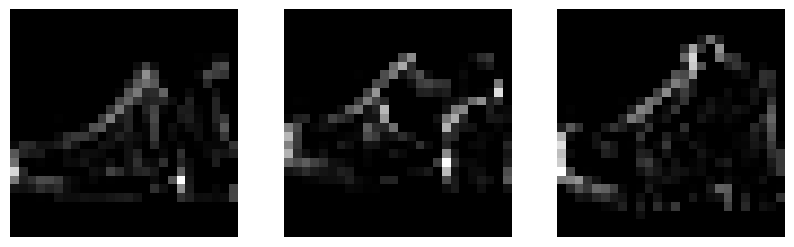

In [33]:
fig = plt.figure(figsize=(10, 8))

# select a kernel of interest
kernel_index = 1

fig.add_subplot(1, 3, 1)
plt.imshow(first_intermediate_output[0, :, :, kernel_index])
plt.axis('off')

fig.add_subplot(1, 3, 2)
plt.imshow(second_intermediate_output[0, :, :, kernel_index])
plt.axis('off')

fig.add_subplot(1, 3, 3)
plt.imshow(third_intermediate_output[0, :, :, kernel_index])
plt.axis('off')

plt.show()

Over the years, variants of this basic architecture have been developed. A good measure of the progress is the **top-five error rate** (number of test images for which the model top five predictions did not include the correct answer) in **competitions** such as the [**ImageNet Large Scale Visual Recognition Challenge (ILSVRC) challenge**](https://image-net.org/challenges/LSVRC/). This challenge has been held annually between 2010 and 2017, and the goal is to train a model that can classify an image into 1.000 separate categories using over 100.000 test images and approximately 1.2 million training images. The images are fairly large (256 pixels high) and some classes are really subtle. Looking at the evolution of the winning entries is a good way to understand how CNNs work, and how research in deep learning progresses. More recent challenges are the [Common Objects in Context (COCO) Detection Challenge](https://cocodataset.org/#home), [PASCAL Visual Object Classes (VOC)) Challenge](http://host.robots.ox.ac.uk/pascal/VOC/), or [Kaggle competitions](https://www.kaggle.com/competitions). These platforms often host exciting challenges that allow researchers and practitioners to showcase their progress in object detection and classification. In the following subsection we revise the most influential architecture proposed over the years.

### LeNet-5

One of the first and most widely known architecture [1998](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) used for handwritten digit recognition. It looks similar to our basic model: a stack of convolutional layers and pooling layers, followed by a dense network. The main difference with more modern classification is the activation functions: today, we would use ReLU instead of tanh and softmax instead of RBF. We try to reproduce the original architecture described in the paper using Keras and using the MNIST dataset:

In [34]:
lenet = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='tanh', padding="same"),
  tf.keras.layers.AvgPool2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
  tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='tanh', padding="valid"),
  tf.keras.layers.AvgPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
  tf.keras.layers.Conv2D(filters=120, kernel_size=(5, 5), activation='tanh', padding="valid"),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=84, activation='tanh'),
  tf.keras.layers.Dense(units=10, activation='softmax')
], name='lenet')

In [35]:
lenet.compile(optimizer='SGD', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Then we load and preprocess the MNIST dataset and then we train the model:

In [36]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

We fit the model only if it is not already trained, we can check progress on the previous TensorBoard:

In [37]:
exists = os.path.exists("models/lenet_model.keras")

if(not exists):
    logdir = os.path.join("models/logs/lenet_model")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    result = lenet.fit(train_images, train_labels, epochs=epochs, 
                       batch_size=128, validation_split=0.2, verbose=0,
                       callbacks=[tensorboard_callback])
    lenet_history = result.history
    np.save('models/lenet_model', lenet_history)
    lenet.save('models/lenet_model.keras')
else:
    lenet = tf.keras.models.load_model("models/lenet_model.keras")   
    lenet_history = np.load('models/lenet_model.npy', allow_pickle='TRUE').item()   


In [38]:
print("Validation accuracy:", '{:.2f}'.format(lenet_history["val_accuracy"][-1]))

Validation accuracy: 0.96


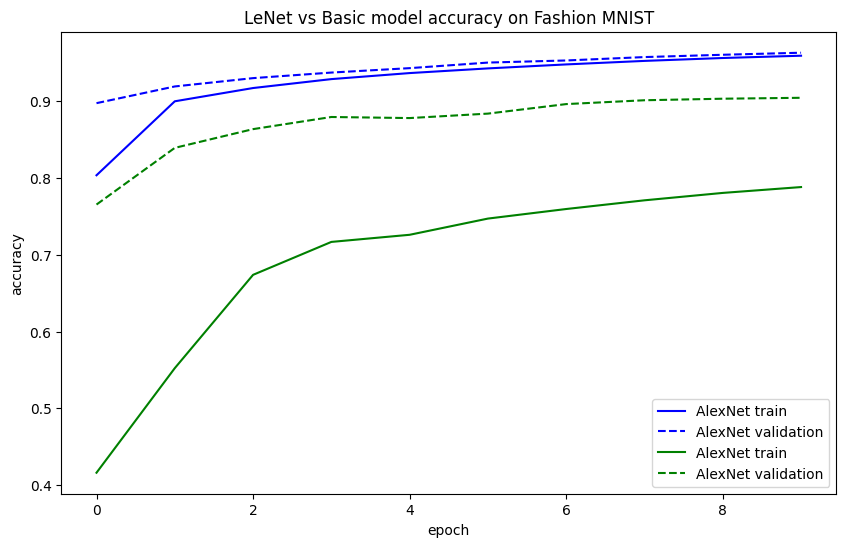

In [39]:
plt.figure(figsize=(10,6))

plt.plot(np.arange(epochs), lenet_history['accuracy'], label='AlexNet train', linestyle='solid', color='blue')
plt.plot(np.arange(epochs), lenet_history['val_accuracy'], label='AlexNet validation', linestyle='dashed', color='blue')

plt.plot(np.arange(epochs), basic_model_history['accuracy'], label='AlexNet train', linestyle='solid', color='green')
plt.plot(np.arange(epochs), basic_model_history['val_accuracy'], label='AlexNet validation', linestyle='dashed', color='green')

plt.title('LeNet vs Basic model accuracy on Fashion MNIST')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

### AlexNet

This architecture ⁠won the [2012](https://papers.nips.cc/paper_files/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html). It is similar to LeNet 5, only much larger and deeper, and it was the first to stack convolutional layers directly on top of one another, instead of stacking a pooling layer on top of each convolutional layer. Moreover, to reduce overfitting, the authors used two regularization techniques: dropout with a 0.5 dropout rate after the outputs of the fully connected layer, and data augmentation by randomly shifting the training images by various offsets, flipping them horizontally, and changing the lighting conditions.

![](images/alexnet.png)

We can implement the orginal architecture in Keras:

In [40]:
alexnet = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(227, 227, 3)),
  tf.keras.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
  tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(4, 4), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
  tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'),
  tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'),
  tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=4096, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(units=4096, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(units=1000, activation='softmax')
], name='alexnet')

In [41]:
alexnet.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Use have used a batch normalization, however AlexNet uses a normalization step immediately after the ReLU of the first two convolutional layers, called **local response normalization (LRN)**. This method is inspired by the lateral inhibition phenomenon in biological neural networks, where excited neurons inhibit the activity of neighboring neurons, enhancing contrast. The idea is to normalize the neuron responses in a way that amplifies the most activated neurons (similar to max pooling but smoother) and suppresses less activated neurons. This encourages a form of lateral inhibition, where strong activations in a particular channel inhibit the responses of neurons in nearby channels, making the network more discriminative and enhancing generalization. Mathematically, the normalized output $b$ of a neuron located in feature map $i$ is the value of the output of the activation $a$ multiplied by:

$\displaystyle b_{i} = a_{i} \left(k + \alpha \sum_{j=max(0, i-r/2)}^{min(i+r/2, f_n-1)} a_j^2 \right)^{-\beta}$

where $k, \alpha, r, \beta$ are hyperparameters, and $f_n$ is the number of feature maps. $k$ is called bias and "r" depth radius   

For example, if $r=2$ and a neuron has a strong activation, it will inhibit the activation of the neurons located in the feature maps immediately above and
below its own. In AlexNet, the hyperparameters are set as: $r=5, \alpha=0.0001, \beta= 075, k=2$

The ImageNet dataset is too big to be used in this notebook (over 150 GB), so we will use the [**CIFAR-100 dataset**](https://paperswithcode.com/sota/image-classification-on-cifar-100), which is a dataset of 60.000 32x32 color images in 100 classes. Objects are not simple, not centered like MNIST and they have distrurbing backgrounds (for example, airplanes might have a cloudy sky behind them). We can load the dataset:

In [42]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar100.load_data()

We can plot some examples of the images in the dataset:

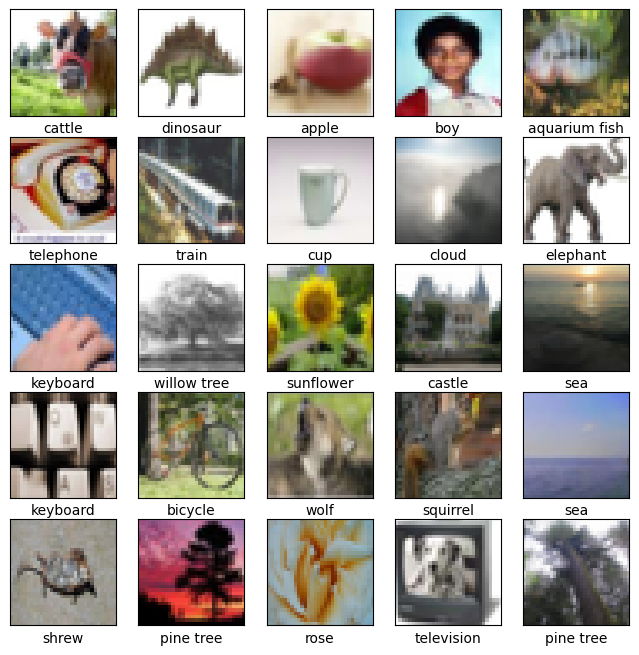

In [43]:
class_names = [
    "apple", "aquarium fish", "baby", "bear", "beaver", "bed", "bee", "beetle",
    "bicycle", "bottle", "bowl", "boy", "bridge", "bus", "butterfly", "camel",
    "can", "castle", "caterpillar", "cattle", "chair", "chimpanzee", "clock",
    "cloud", "cockroach", "couch", "cra", "crocodile", "cup", "dinosaur", "dolphin",
    "elephant", "flatfish", "forest", "fox", "girl", "hamster", "house", "kangaroo",
    "keyboard", "lamp", "lawn-mower", "leopard", "lion", "lizard", "lobster", "man",
    "maple tree", "motorcycle", "mountain", "mouse", "mushroom", "oak tree", "orange",
    "orchid", "otter", "palm tree", "pear", "pickup truck", "pine tree", "plain", 
    "plate", "poppy", "porcupine", "possum", "rabbit", "raccoon", "ray", "road", 
    "rocket", "rose", "sea", "seal", "shark", "shrew", "skunk", "skyscraper", 
    "snail", "snake", "spider", "squirrel", "streetcar", "sunflower", "sweet-pepper", 
    "table", "tank", "telephone", "television", "tiger", "tractor", "train", "trout", 
    "tulip", "turtle", "wardrobe", "whale", "willow tree", "wolf", "woman", "worm"
]

plt.figure(figsize=[8,8])
for i in range (25):    
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.binary)
  plt.xlabel(class_names[train_labels[i][0]])
  

We preprocess the images:

In [44]:
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

We need to adapt AlexNet to work with CIFAR-10 dataset, which has 100 classes instead of 1.000 and the images are 32x32 pixels instead of 256x256. We can use the same architecture, but we need to change the input shape, the number of classes and also some parameters in the convolutional layers in order to not reduce the image size too much:

In [45]:
alexnet_reduced = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(32, 32, 3)),
  tf.keras.layers.Conv2D(filters=96, kernel_size=(5, 5), strides=(1, 1), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
  tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
  tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'),
  tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'),
  tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=4096, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(units=4096, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(units=100, activation='softmax')
], name='alexnet_reduced')

In [46]:
alexnet_reduced.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

In [47]:
exists = os.path.exists("models/alexnet_model.keras")

if(not exists):
    logdir = os.path.join("models/logs/alexnet_model")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    results = alexnet_reduced.fit(train_images, train_labels, epochs=epochs, verbose=0, 
                                  validation_data=(test_images, test_labels),
                                  callbacks=[tensorboard_callback])

    alexnet_reduced_history = results.history
    np.save('models/alexnet_model', alexnet_reduced_history)
    alexnet_reduced.save('models/alexnet_model.keras')
else:
    alexnet_reduced = tf.keras.models.load_model("models/alexnet_model.keras")   
    alexnet_reduced_history = np.load('models/alexnet_model.npy', allow_pickle='TRUE').item()   

In [48]:
print("Validation accuracy:", '{:.2f}'.format(alexnet_reduced_history["val_accuracy"][-1]))

Validation accuracy: 0.46


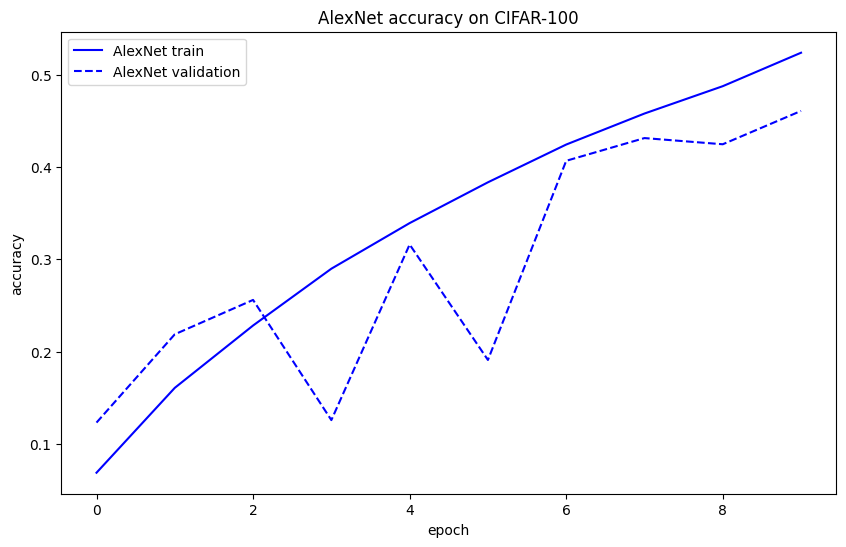

In [49]:
plt.figure(figsize=(10,6))

plt.plot(np.arange(epochs), alexnet_reduced_history['accuracy'], label='AlexNet train', linestyle='solid', color='blue')
plt.plot(np.arange(epochs), alexnet_reduced_history['val_accuracy'], label='AlexNet validation', linestyle='dashed', color='blue')

plt.title('AlexNet accuracy on CIFAR-100')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

### GoogLeNet

It is also known as **Inception v1**, is an architecture introduced by Google in [2014](https://arxiv.org/abs/1409.4842) and it won the ILSVRC challenge in the same year. The architecture is known for its innovative approach to handling computational efficiency and depth in neural networks. Prior to its introduction, CNNs just stacked convolution layers deeper and deeper, hoping to get better performance. However, images can have extremely large variation in size and objects can appear at different scales. Because of this huge variation, choosing the right kernel size for the convolution operation becomes tough. A larger kernel is preferred for information that is distributed more globally, and a smaller kernel is preferred for information that is distributed more locally. The idea was to have **parallel kernels with multiple sizes** operate on the same level, called **inception modules**. In that way we can let the network learn the best filter size for each layer. For example, we can have an inception module that performs convolution on an input, with three different sizes of kernels, then The outputs are concatenated and be sent to the next layer: 

![](images/inception-module.png)

Since convolution are computationally expensive, authors **limit the number of input channels** by adding an **extra 1x1 convolution operation** before each NxM convolutions. Though adding an extra operation may seem counterintuitive, however 1x1 convolutions are far more cheaper than other convolutions, and can to reduce the number of feature maps while preserving the image sizes and not introducing many parameters. The network was built with this idea and it was much deeper than previous CNN: GoogLeNet has 9 inception modules stacked linearly, so it is 22 layers deep (27, including the pooling layers). It uses global average pooling at the end of the last inception module in order to reduce the number of feature maps. Thanks to this ideas, GoogLeNet actually has 10 times fewer parameters than AlexNet (roughly 6 million instead of 60 million).

![](images/googlenet.png)

Needless to say, it is a pretty deep classifier. As with any very deep network, it is subject to the vanishing gradient problem. To prevent the middle part of the network from “dying out”, the authors introduced two auxiliary classifiers. They essentially applied softmax to the outputs of two of the inception modules, and computed an auxiliary loss over the same labels. The total loss function is a weighted sum of the auxiliary loss and the real loss. 

More advanced version, **Inception v2** and **Inception v3**, propose a number of upgrades which increased the accuracy and reduced the computational complexity. In particular, they reduce the **representational bottleneck** of convolutions (which is the loss of information caused be an excessive reducing of the dimensions) and use smart factorization methods to make convolution moee efficient in terms of computational complexity.

In general, we won’t have to implement standard models like GoogLeNet manually, since **pretrained networks are readily available**. For example, we can load the ResNet-50 model, pretrained on ImageNet from Keras or other sources. As a refrence, the updated list of all models available in Keras can be found [here](https://keras.io/api/applications/).

In [50]:
googlenet_imagenet = tf.keras.applications.InceptionV3(weights="imagenet")

But what if we want to use an image classifier for classes of images that are not part of ImageNet, for example from CIFAR-100? In that case, we may still benefit from the pretrained models by using them to perform transfer learning. We need to load the model excluding the top of the network:

In [51]:
base_googlenet_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False)

It’s usually a good idea to freeze the weights of the pretrained layers, at least at the beginning of training:

In [52]:
for layer in base_googlenet_model.layers:
    layer.trainable = False

Since the CIFAR-100 image data-set is of 32x32 RGB images, in order to match ImageNet (224x224) dataset we need a resizing. Then we need to add our own global average pooling layer (feeding it the output of the base model), followed by some dense output layers with one unit per class, using the softmax activation function:

In [53]:
googlenet = tf.keras.models.Sequential(name='googlenet')
googlenet.add(tf.keras.layers.Resizing(height=224, width=224, interpolation="bilinear"))
googlenet.add(base_googlenet_model)
googlenet.add(tf.keras.layers.GlobalAveragePooling2D())
googlenet.add(tf.keras.layers.Dense(256, activation='relu'))
googlenet.add(tf.keras.layers.Dropout(.25))
googlenet.add(tf.keras.layers.BatchNormalization())
googlenet.add(tf.keras.layers.Dense(100, activation='softmax'))

Normally pretrained models assume that the images are preprocessed in a specific way. In some cases they may expect the inputs to be scaled from 0 to 1, or
from –1 to 1, and so on. Each model provides a preprocess_input() function that we can use to preprocess our images. These functions assume that the original pixel values range from 0 to 255, which is the case here:

In [54]:
from keras.applications.inception_v3 import preprocess_input

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar100.load_data()

train_images_preprocessed = preprocess_input(train_images)
test_images_preprocessed = preprocess_input(test_images)

train_labels = to_categorical(train_labels, 100)
test_labels = to_categorical(test_labels, 100)

Finally, we can compile the model and start training:

In [55]:
googlenet.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

Again we start the training only if the model is not already trained:

In [56]:
exists = os.path.exists("models/googlenet_model.keras")

if(not exists):
    
    logdir = os.path.join("models/logs/googlenet_model")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    results = googlenet.fit(train_images_preprocessed, train_labels,
                            epochs=epochs, verbose=0, 
                            validation_data=(test_images_preprocessed, test_labels),
                            callbacks=[tensorboard_callback])

    googlenet_history = results.history
    np.save('models/googlenet_model', googlenet_history)
    googlenet.save('models/googlenet_model.keras')
else:
    googlenet = tf.keras.models.load_model("models/googlenet_model.keras")   
    googlenet_history = np.load('models/googlenet_model.npy', allow_pickle='TRUE').item()   

In [57]:
print("Validation accuracy:", '{:.2f}'.format(googlenet_history["val_accuracy"][-1]))

Validation accuracy: 0.63


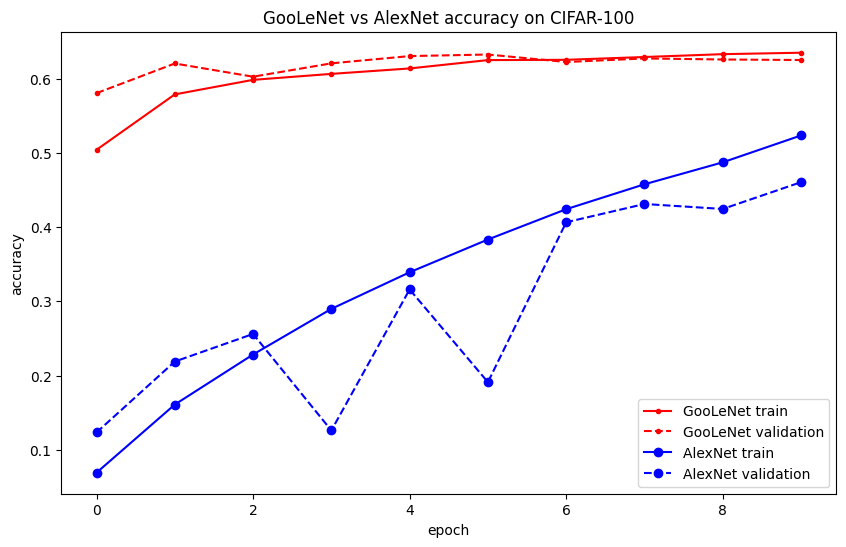

In [58]:
plt.figure(figsize=(10,6))

plt.plot(np.arange(epochs), googlenet_history['accuracy'], label='GooLeNet train', linestyle='solid', color='red', marker='.')
plt.plot(np.arange(epochs), googlenet_history['val_accuracy'], label='GooLeNet validation', linestyle='dashed', color='red', marker='.')

plt.plot(np.arange(epochs), alexnet_reduced_history['accuracy'], label='AlexNet train', linestyle='solid', color='blue', marker='o')
plt.plot(np.arange(epochs), alexnet_reduced_history['val_accuracy'], label='AlexNet validation', linestyle='dashed', color='blue', marker='o')

plt.title('GooLeNet vs AlexNet accuracy on CIFAR-100')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

We get a test accuracy quite impressive.

### ResNet

Models like AlexNet and GoogLeNMet made significant strides in computer vision using CNNs. However, when researchers attempted to create even deeper networks, they encountered a problem known as the **degradation issue**. Adding more layers led to reduced training accuracy, which was unexpected. The Residual Network introduced in [2015](https://arxiv.org/abs/1512.03385) was an extremely deep network (152 layers) and the key idea to train such a deep network is to use **skip connections**. The signal feeding into a layer is also added to the output of a layer located higher up the stack. When we train a neural network, the goal is to make it model a target function $h(x)$. If we add the input $x$ to the output of the network (this is the skip connection), then the network will be forced to model: 

$\displaystyle f(x) = h(x) – x$ 

rather than $h(x)$. This is called **residual learning**:

![](images/residual-learning.png)

When we initialize a regular neural network, its weights are close to zero, so the network just outputs values close to zero. If we add a skip connection, the resulting network just outputs a copy of its inputs, in other words, it initially models the identity function. If the target function is fairly close to the identity function, this will speed up training considerably. Moreover, if we add many skip connections, the network can start making progress even if several layers have not started learning yet. Thanks to skip connections, the signal can easily make its way across the whole network. The deep residual network can be seen as a stack of **residual units (RUs)**, where each residual unit is a small neural network with a skip connection:

![](images/residual-and-gradient.png)

In summary, skip connections enable neural networks to learn from early layers by providing a direct path for gradients and allowing the network to focus on learning residuals. This architectural innovation has been crucial in building deeper and more expressive models. In particular,the architecture of ResNet is surprisingly simple. It starts and ends exactly like GoogLeNet and in between is just a very deep stack of residual units. Each residual unit is composed of two convolutional layers (and no pooling layer), with batch normalization and ReLU activation, using 3×3 kernels and preserving spatial dimensions (stride 1, "same" padding):

![](images/resnet.png)



Notice that the number of feature maps is doubled every few residual units, at the same time as their height and width are halved (using a convolutional
layer with stride 2). In this way, ResNet achieves a **balance between expressive power** (due to increased feature maps) **and computational efficiency** (due to reduced spatial dimensions). This design choice allows ResNet to handle very deep architectures effectively. However, inputs cannot be added directly to outputs of the residual unit, because they don’t have the same shape. To solve this problem, the inputs are passed through a 1×1 convolutional layer with stride 2 and the right number of output feature maps (not showed in the diagram). We can load the ResNet-50 model, pretrained on ImageNet from Keras:

In [59]:
base_resnet_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)

for layer in base_resnet_model.layers:
    layer.trainable = False

In [60]:
resnet = tf.keras.models.Sequential(name='resnet')
resnet.add(tf.keras.layers.Resizing(height=224, width=224, interpolation="bilinear"))
resnet.add(base_resnet_model)
resnet.add(tf.keras.layers.GlobalAveragePooling2D())
resnet.add(tf.keras.layers.Dense(256, activation='relu'))
resnet.add(tf.keras.layers.Dropout(.25))
resnet.add(tf.keras.layers.BatchNormalization())
resnet.add(tf.keras.layers.Dense(100, activation='softmax'))

We preprocess the CIFAR-100 images in order to match the pre-trained model expectations:

In [61]:
from keras.applications.resnet50 import preprocess_input

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar100.load_data()

train_images_preprocessed = preprocess_input(train_images)
test_images_preprocessed = preprocess_input(test_images)

train_labels = to_categorical(train_labels, 100)
test_labels = to_categorical(test_labels, 100)

Finally, we can compile the model and start training:

In [62]:
resnet.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, nesterov=True), 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

In [63]:
exists = os.path.exists("models/resnet_model.keras")

if(not exists):
    logdir = os.path.join("models/logs/resnet_model")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    results = resnet.fit(train_images_preprocessed, train_labels,
                         epochs=epochs, verbose=0,
                         validation_data=(test_images_preprocessed, test_labels),
                         callbacks=[tensorboard_callback])
              
    resnet_history = results.history
    np.save('models/resnet_model', resnet_history)
    resnet.save('models/resnet_model.keras')
else:
    resnet = tf.keras.models.load_model("models/resnet_model.keras")   
    resnet_history = np.load('models/resnet_model.npy', allow_pickle='TRUE').item()   

In [64]:
print("Validation accuracy:", '{:.2f}'.format(resnet_history["val_accuracy"][-1]))

Validation accuracy: 0.73


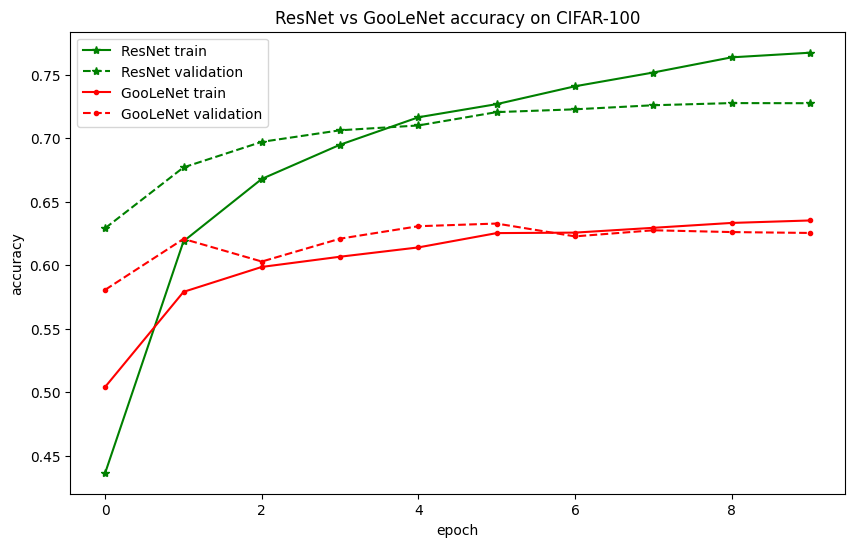

In [65]:
plt.figure(figsize=(10,6))

plt.plot(np.arange(epochs), resnet_history['accuracy'], label='ResNet train', linestyle='solid', color='green', marker='*')
plt.plot(np.arange(epochs), resnet_history['val_accuracy'], label='ResNet validation', linestyle='dashed', color='green', marker='*')

plt.plot(np.arange(epochs), googlenet_history['accuracy'], label='GooLeNet train', linestyle='solid', color='red', marker='.')
plt.plot(np.arange(epochs), googlenet_history['val_accuracy'], label='GooLeNet validation', linestyle='dashed', color='red', marker='.')

plt.title('ResNet vs GooLeNet accuracy on CIFAR-100')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

Different variations of the architecture exist, with different numbers of layers (e.g. ResNet-43, ResNet-50, ResNet-101, ResNet-152). Google Inception-v4⁠ architecture merged the ideas of GoogLeNet and ResNet.

### Xception and MobileNet

A variant of the GoogLeNet architecture, Xception (**Extreme Inception**) was proposed in [2016](https://arxiv.org/abs/1610.02357) It merges the ideas of GoogLeNet and ResNet (like Inception-v4), but it replaces the inception modules with a special type of layer called a **depthwise separable convolution** layer. In order to undestand the idea, consider a standard convolution of an input data with a kernel:

![](images/normal-convolution.png)

The number of multiplications in one convolution operation is:

$\displaystyle f_w \cdot f_h \cdot n_c$ 

since the kerner slides horizontally and vertically:

$\displaystyle f_w \cdot  f_h \cdot n_c \cdot d_w \cdot d_h$

finally, we can have more than one filter, so the total number of multiplications is:

$\displaystyle f_w \cdot f_h \cdot n_c \cdot d_w \cdot d_h \cdot n_f$

This operation is quite complicated, we can break it down into smaller pieces more efficient to run on hardware. Instead of doing one compound convolution, we use two simpler steps. First, each channel is treated independently as if they were separate single-channel images and filters are applied to them creating multiple outputs (**depthwise convolution**):

![](images/depthwise-convolution.png)

A single convolution operation now requires a number of multiplications equal to:

$\displaystyle f_w \cdot f_h $ 

since the number of channels is the same as the number of filters, the total number of multiplications is:

$\displaystyle f_w \cdot f_h \cdot n_c \cdot d_w \cdot d_h$

Next a 1x1 kernel is applied to those outputs (**pointwise convolution**) to compute the final output:

![](images/pointwise-convolution.png)

The number of multiplications in the pointwise convolution is:

$\displaystyle d_w \cdot d_h \cdot n_c$

Just like in regular convolutions, we don’t use a single filter, we will use multiple filters. Those multiple filters occur in the pointwise step:

$\displaystyle d_w \cdot d_h \cdot n_c \cdot n_f$

The overall total number of multiplications for depthwise separable convolution is the sum of the depthwise and pointwise multiplications:

$\displaystyle (f_w \cdot f_h \cdot n_c \cdot d_w \cdot d_h) + (d_w \cdot d_h \cdot n_c \cdot n_f) = d_w \cdot d_h \cdot n_c \cdot (f_w \cdot f_h + n_f)$

We can compare the two kinds of convolutions through a ratio of the number of multiplications required for each:

$\displaystyle \frac{d_w \cdot d_h \cdot n_c \cdot (f_w \cdot f_h + n_f)}{f_w \cdot f_h \cdot n_c \cdot d_w \cdot d_h \cdot n_f} = \frac{f_w \cdot f_h + n_f}{f_w \cdot f_h \cdot n_f} = \frac{1}{n_f} + \frac{1}{f_w \cdot f_h}$

This means that the more filters we use and the larger the kernels are, the more multiplications we can save, and we also have a much smaller memory requirement as we have fewer parameters to store. However, there is a tradeoff: in improving latency and memory needs, we reduce the number of parameters that the algorithm can use to learn. Thus we are limiting the expressiveness of the model While a regular convolutional layer uses filters that try to simultaneously capture spatial patterns (e.g., an oval) and cross-channel patterns (e.g., mouth + nose + eyes = face), a separable convolutional layer makes the strong assumption that spatial patterns and cross-channel patterns can be modeled separately. Thus, the two parts: the first applies spatial filter to each input feature map, then the second part looks exclusively for cross-channel patterns.

[**MobileNets**](https://arxiv.org/abs/1704.04861) are based on depthwise separable convolutional layers, like Xception, but they trade a bit of accuracy for faster and smaller models,  making them popular in mobile and web applications. The **depthwise multiplier** is introduced to control the number of channels that we are looking at within each layer:

$\displaystyle f_w \cdot f_h \cdot \alpha n_c \cdot d_w \cdot d_h + d_w \cdot d_h \cdot \alpha n_c \cdot \alpha n_f$

Then the **resolution multiplier** is introduced to control the input image resolution:

$\displaystyle f_w \cdot f_h \cdot \alpha n_c \cdot \rho d_w \cdot \rho d_h + \rho d_w \cdot \rho d_h \cdot \alpha n_c \cdot \alpha n_f$

Modifying the two parameters we can control the size and complexity of the model. However, the tradeoff is that the model will be less accurate.

We can try a MobileNet model on the CIFAR-100 dataset using transfer learning:

In [66]:
base_mobilenet_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_mobilenet_model.layers:
    layer.trainable = False

In [67]:
mobilenet = tf.keras.models.Sequential(name='mobilenet')
mobilenet.add(tf.keras.layers.Resizing(height=224, width=224, interpolation="bilinear"))
mobilenet.add(base_mobilenet_model)
mobilenet.add(tf.keras.layers.GlobalAveragePooling2D())
mobilenet.add(tf.keras.layers.Dense(256, activation='relu'))
mobilenet.add(tf.keras.layers.Dropout(.25))
mobilenet.add(tf.keras.layers.BatchNormalization())
mobilenet.add(tf.keras.layers.Dense(100, activation='softmax'))

In [68]:
from keras.applications.mobilenet_v2 import preprocess_input

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar100.load_data()

train_images_preprocessed = preprocess_input(train_images)
test_images_preprocessed = preprocess_input(test_images)

train_labels = to_categorical(train_labels, 100)
test_labels = to_categorical(test_labels, 100)

In [69]:
mobilenet.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

In [70]:
exists = os.path.exists("models/mobilenet_model.keras")

if(not exists):
    logdir = os.path.join("models/logs/mobilenet_model")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    results = mobilenet.fit(train_images_preprocessed, train_labels,
                            epochs=epochs, verbose=0,
                            validation_data=(test_images_preprocessed, test_labels),
                            callbacks=[tensorboard_callback])
              
    mobilenet_history = results.history
    np.save('models/mobilenet_model', mobilenet_history)
    mobilenet.save('models/mobilenet_model.keras')
else:
    mobilenet = tf.keras.models.load_model("models/mobilenet_model.keras")   
    mobilenet_history = np.load('models/mobilenet_model.npy', allow_pickle='TRUE').item()   

In [71]:
print("Validation accuracy:", '{:.2f}'.format(mobilenet_history["val_accuracy"][-1]))

Validation accuracy: 0.62


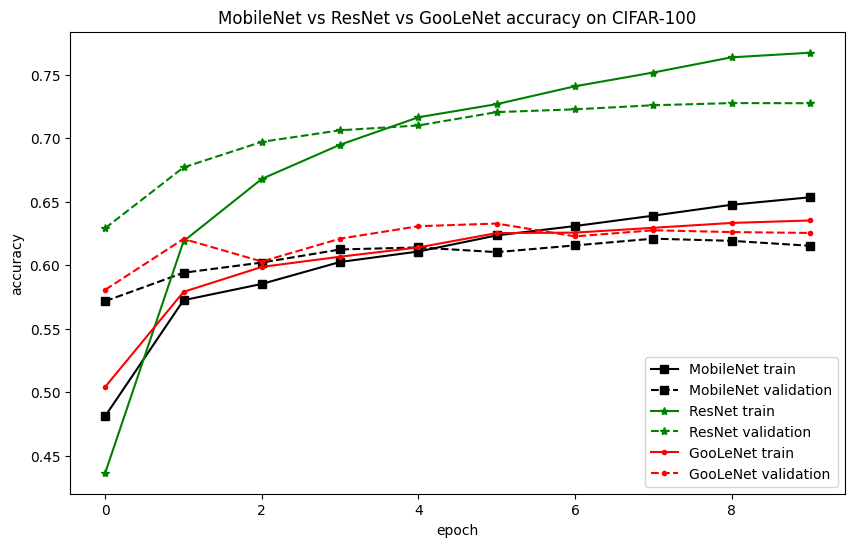

In [72]:
plt.figure(figsize=(10,6))

plt.plot(np.arange(epochs), mobilenet_history['accuracy'], label='MobileNet train', linestyle='solid', color='black', marker='s')
plt.plot(np.arange(epochs), mobilenet_history['val_accuracy'], label='MobileNet validation', linestyle='dashed', color='black', marker='s')

plt.plot(np.arange(epochs), resnet_history['accuracy'], label='ResNet train', linestyle='solid', color='green', marker='*')
plt.plot(np.arange(epochs), resnet_history['val_accuracy'], label='ResNet validation', linestyle='dashed', color='green', marker='*')

plt.plot(np.arange(epochs), googlenet_history['accuracy'], label='GooLeNet train', linestyle='solid', color='red', marker='.')
plt.plot(np.arange(epochs), googlenet_history['val_accuracy'], label='GooLeNet validation', linestyle='dashed', color='red', marker='.')

plt.title('MobileNet vs ResNet vs GooLeNet accuracy on CIFAR-100')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

MobileNet trades off some accuracy for a much smaller model and faster predictions. This can be useful in mobile and web applications where speed and size are important:

In [73]:
import os

alexnet_file_size = os.path.getsize('models/alexnet_model.keras')
googlenet_file_size = os.path.getsize('models/googlenet_model.keras')
resnet_file_size = os.path.getsize('models/resnet_model.keras')
mobilenet_file_size = os.path.getsize('models/mobilenet_model.keras')

print('The size of the AlexNet model is', '{:.1f}'.format(alexnet_file_size/(1024*1024)), 'MB')
print('The size of the GoogLeNet model is', '{:.1f}'.format(googlenet_file_size/(1024*1024)), 'MB')
print('The size of the ResNet model is', '{:.1f}'.format(resnet_file_size/(1024*1024)), 'MB')
print('The size of the MobileNet model is', '{:.1f}'.format(mobilenet_file_size/(1024*1024)), 'MB')

The size of the AlexNet model is 191.6 MB
The size of the GoogLeNet model is 90.5 MB
The size of the ResNet model is 94.8 MB
The size of the MobileNet model is 13.2 MB


### EfficientNet

There are a whole variety of different optimizations we can perform across a number of channels we applied, the number of filters we are applying, what the parameters value are, and the whole bunch of different hyperparameters we can tune. CNN are commonly developed at a fixed resource budget and then **scaled up** for better accuracy if more resources are available. In particular, a network can be scaled by several dimensions:

- **depth**: increasing the number of layers allows the network to learn more complex features and representations. However, deeper networks require more computational resources and  can lead to vanishing gradient problems;
- **width**: increasing the number of kernerls enhances the network capacity to capture diverse features and representations. However, this can lead to a large model size and overfitting;
- **resolution**: increasing the resolution of input images provides finer-grained details to the network, which can improve its ability to distinguish between classes. However, higher resolutions can significantly increase the computational cost.

![](images/model-scaling.png)

Though it is possible to scale the three dimensions arbitrarily, it requires tedious manual tuning
and still often yields sub-optimal accuracy and efficiency. [EfficientNet](https://arxiv.org/abs/1905.11946) proposed a method to scale a CNN efficiently, called **compound scaling**. The key idea is to find a principled way to scale each dimension of the network so that the resulting model is well-balanced in terms of computational resources and accuracy. The compound scaling method proposes scaling each dimension with **a fixed ratio**, the idea behind is that **if the input image is larger, the network needs more layers to capture fine-grained patterns and more channels to handle the increased receptive field**:

- depth: $\displaystyle d = \alpha^{\theta}$
- width: $\displaystyle w = \beta^{\theta}$
- resolution: $\displaystyle r = \gamma^{\theta}$

where $\alpha, \beta, \gamma$ are the **scaling coefficients**, and $\theta$ is a the hyperparameter that that controls how much the network should be scaled. The authors performed a grid search to find optimal values of the parameters that results in a model with the best trade-off between accuracy and efficiency. 

Moreovere, they used a **neural architecture search** technique (essentially the automation of process of manually tweaking a neural network to discover more complex architectures) to find a good architecture on a scaled-down version of ImageNet (with smaller and fewer images), and then used compound scaling to create larger and larger versions of this architecture. EfficientNet models vastly outperformed all existing models, across all compute budgets, and they remain among the best models out there today. Again, we can try to use a pre-trained EfficientNet model on the CIFAR-100 dataset using transfer learning:

In [74]:
base_efficientnet_model = tf.keras.applications.EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_efficientnet_model.layers:
    layer.trainable = False

In [75]:
efficientnet = tf.keras.models.Sequential(name='efficientnet')
efficientnet.add(tf.keras.layers.Resizing(height=224, width=224, interpolation="bilinear"))
efficientnet.add(base_efficientnet_model)
efficientnet.add(tf.keras.layers.GlobalAveragePooling2D())
efficientnet.add(tf.keras.layers.Dense(256, activation='relu'))
efficientnet.add(tf.keras.layers.Dropout(.25))
efficientnet.add(tf.keras.layers.BatchNormalization())
efficientnet.add(tf.keras.layers.Dense(100, activation='softmax'))

In [76]:
from keras.applications.efficientnet import preprocess_input

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar100.load_data()

train_images_preprocessed = preprocess_input(train_images)
test_images_preprocessed = preprocess_input(test_images)

train_labels = to_categorical(train_labels, 100)
test_labels = to_categorical(test_labels, 100)

In [77]:
efficientnet.compile(optimizer='adam', 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

In [78]:
exists = os.path.exists("models/efficientnet_model.keras")

if(not exists):
    logdir = os.path.join("models/logs/efficientnet_model")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    results = efficientnet.fit(train_images_preprocessed, train_labels,
                               epochs=epochs, verbose=0,
                               validation_data=(test_images_preprocessed, test_labels),
                               callbacks=[tensorboard_callback])
              
    efficientnet_history = results.history
    np.save('models/efficientnet_model', efficientnet_history)
    efficientnet.save('models/efficientnet_model.keras')
else:
    efficientnet = tf.keras.models.load_model("models/efficientnet_model.keras")   
    efficientnet_history = np.load('models/efficientnet_model.npy', allow_pickle='TRUE').item()   

In [79]:
print("Validation accuracy:", '{:.2f}'.format(efficientnet_history["val_accuracy"][-1]))

Validation accuracy: 0.68


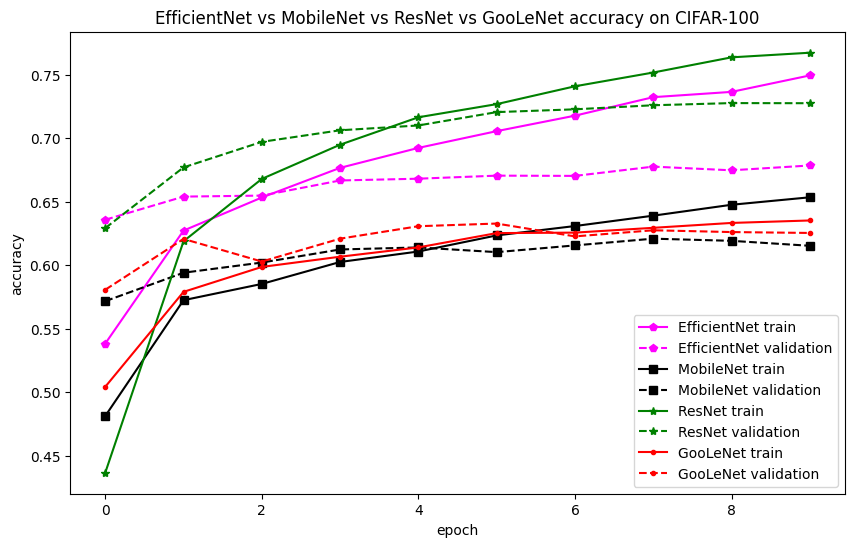

In [80]:
plt.figure(figsize=(10,6))

plt.plot(np.arange(epochs), efficientnet_history['accuracy'], label='EfficientNet train', linestyle='solid', color='magenta', marker='p')
plt.plot(np.arange(epochs), efficientnet_history['val_accuracy'], label='EfficientNet validation', linestyle='dashed', color='magenta', marker='p')

plt.plot(np.arange(epochs), mobilenet_history['accuracy'], label='MobileNet train', linestyle='solid', color='black', marker='s')
plt.plot(np.arange(epochs), mobilenet_history['val_accuracy'], label='MobileNet validation', linestyle='dashed', color='black', marker='s')

plt.plot(np.arange(epochs), resnet_history['accuracy'], label='ResNet train', linestyle='solid', color='green', marker='*')
plt.plot(np.arange(epochs), resnet_history['val_accuracy'], label='ResNet validation', linestyle='dashed', color='green', marker='*')

plt.plot(np.arange(epochs), googlenet_history['accuracy'], label='GooLeNet train', linestyle='solid', color='red', marker='.')
plt.plot(np.arange(epochs), googlenet_history['val_accuracy'], label='GooLeNet validation', linestyle='dashed', color='red', marker='.')

plt.title('EfficientNet vs MobileNet vs ResNet vs GooLeNet accuracy on CIFAR-100')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

## Object detection

There’s more in computer vision than just classification. For example, what if we also want to know **where** an object is in a picture? For example, imagine a self-driving car that needs to detect other cars on the road. The **localization** can be expressed as a **regression task**: to predict a **bounding box** around the object. There are several ways to represent a bounding box:
- top-left point with width and height (x0, y0, w, h);
- top-left point and bottom-right point (x0 ,y0 ,x1 ,y1); 
- center point with width and height (xc, yc, w, h)

![](images/bounding-box.png)

### Localization

We have four numbers to predict and we start with the simple case of detecting (**localizing**) of a single object. It does not require much change to the previous model. We just need to add a second dense output layer (**head**) with four units (typically on top of the global average pooling layer), and it can be trained using the MSE loss. 

![](images/localization-architecture.png)

In [504]:
image_size = 64
object_types = 4

inputs = tf.keras.layers.Input(shape=(image_size, image_size, 1))
x = tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation="relu")(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
class_out = tf.keras.layers.Dense(object_types, activation="softmax", name="class")(x)
box_out = tf.keras.layers.Dense(4, name="box")(x)

localization_model = tf.keras.Model(inputs=inputs, outputs=(class_out, box_out))

But we have a problem, the CIFAR-100 dataset does not have bounding boxes around the objects. So, we need to add them ourselves. This is often **one of the hardest and most costly parts of a machine learning project: getting the labels**. To annotate images with bounding boxes, we may want to use an **image labeling tool** (like [VGG Image Annotator](https://www.robots.ox.ac.uk/~vgg/software/via/), [LabelImg](https://viso.ai/computer-vision/labelimg-for-image-annotation/) or [OpenLabeler](https://github.com/kinhong/OpenLabeler), or we may also consider **crowdsourcing platforms** such as [Amazon Mechanical Turk](https://www.mturk.com/) if we have a very large number of images to annotate. However, it is quite a lot of work.  We can also check if it exists some open-source dataset that we can use for our project. An interesting resource is the ["50+ Object Detection Datasets from different industry domains"](https://towardsai.net/p/computer-vision/50-object-detection-datasets-from-different-industry-domains) article, which isa a collection of annotated datasets for industries such as Fashion, Retail, Sports, Medicine and many more.

In order to introduce the concept, we’ll apply two simplifications: we don’t use real pictures, but images with abstract geometric shapes (this allows us to bootstrap the image data and use simpler neural networks), we predict a fixed number of objects in each image (this makes the entire algorithm a lot easier. In particular, we create a synthetic dataset composed of gray scale images with black background, displaying one of three shapes: a rectangle, a circle, or a triangle or nothing. We use a one-hot encoding vector, where the first four positions are responsible for classifying the shape (nothing, rectangle, circle, triangle), and the last four for the bounding box (top-left corner, widht and height):

In [485]:
import cv2

def add_rectangle(image, min_size, max_size):
    img_size = image.shape   
    w = np.random.randint(min_size, max_size)
    h = np.random.randint(min_size, max_size) 
    x = np.random.randint(0, img_size[0]-w)  
    y = np.random.randint(0, img_size[1]-h) 
    cv2.rectangle(image, (x,y), (x+w, y+h), (255, 255, 255), -1)
    return [0, 1, 0, 0, x, y, w, h]

In [486]:
def add_circle(image, min_size, max_size):
    img_size = image.shape
    radius = np.random.randint(min_size // 2, max_size // 2)
    x = np.random.randint(radius, img_size[0]-radius)  
    y = np.random.randint(radius, img_size[1]-radius) 
    cv2.circle(image, (x, y), radius, (255, 255, 255), -1)
    return [0, 0, 1, 0, x-radius, y-radius, radius*2, radius*2]

In [487]:
def add_triangle(image, min_size, max_size):
    img_size = image.shape
    w = np.random.randint(min_size, max_size)
    h = np.random.randint(min_size, max_size)
    x = np.random.randint(0, img_size[0]-w)
    y = np.random.randint(0, img_size[1]-h)
    pts = [(x,y), (x+w, y), (x+w//2, y+h)]
    cv2.drawContours(image, [np.array(pts)], 0, (255, 255, 255), -1)
    return [0, 0, 0, 1, x, y, w, h]

In [488]:
def add_nothing(image, min_size, max_size):
    return [1, 0, 0, 0, 0, 0, 0, 0]

In [489]:
def create_single_object_image(img_size, shape_type, min_size, max_size):
    image = np.zeros((img_size, img_size), dtype=np.uint8)
    if shape_type == 'circle':
        object_info = add_circle(image, min_size, max_size)
    elif shape_type == 'rectangle':
        object_info = add_rectangle(image, min_size, max_size)
    elif shape_type == 'triangle':
        object_info = add_triangle(image, min_size, max_size)
    elif shape_type == 'nothing':
        object_info = add_nothing(image, min_size, max_size)
    return image, object_info

In [490]:
from sklearn.utils import shuffle

n_samples_per_class = 10000
min_size = 10
max_size = 50

X = []
Y = []

for i in range(n_samples_per_class):
    image, info = create_single_object_image(image_size, 'rectangle', min_size, max_size)
    X.append(image)
    Y.append(info)

for i in range(n_samples_per_class):
    image, info = create_single_object_image(image_size, 'circle', min_size, max_size)
    X.append(image)
    Y.append(info)

for i in range(n_samples_per_class):
    image, info = create_single_object_image(image_size, 'triangle', min_size, max_size)
    X.append(image)
    Y.append(info)

for i in range(n_samples_per_class):
    image, info = create_single_object_image(image_size, 'nothing', min_size, max_size)
    X.append(image)
    Y.append(info)

X, Y = shuffle(X, Y)

X = np.array(X)
Y = np.array(Y)

print("X: ", X.shape)
print("Y: ", Y.shape)

X:  (40000, 64, 64)
Y:  (40000, 8)


We also implement a function that translates the one-hot encoding vector into a written label:

In [570]:
labels = ['nothing', 'rect', 'circle', 'triangle']

def onehot2label(onehot_vec):
    return labels[np.argmax(onehot_vec)]

Now let’s display some of our data to see if it worked out properly:

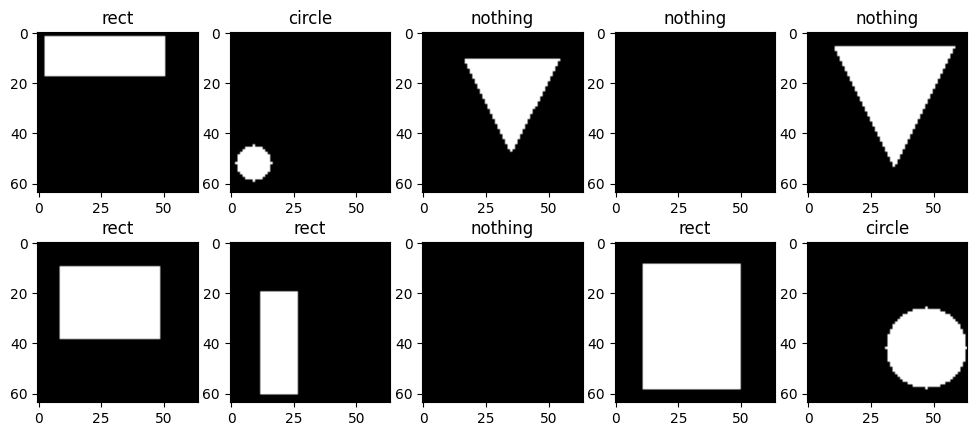

In [493]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(X[i], "gray")
    plt.title(onehot2label(Y[i, :3]) )

plt.show()

The next step is to split the dataset into training, validation, and test set:

In [494]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2)

# further split train_val
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.2, random_state=29)

print("Shape X train:\t  ", X_train.shape)  # (19200, 64, 64, 1)
print("Shape X validate: ", X_val.shape)    # (4800, 64, 64, 1)
print("Shape X test:\t  ", X_test.shape)

Shape X train:	   (25600, 64, 64)
Shape X validate:  (6400, 64, 64)
Shape X test:	   (8000, 64, 64)


For the two heads of the network (regression and classification) we need to split the target vector Y:

In [502]:
Y_train_split = (Y_train[:, :4], Y_train[:, 4:])
Y_val_split = (Y_val[:, :4], Y_val[:, 4:])
Y_test_split = (Y_test[:, :4], Y_test[:, 4:])

The networks goal is to predict the bounding box, as well as the class of the object. Hence, **we have a regression, as well as a classification problem**. For regression problems, the Mean Squared Error is generally an appropriate loss function, whereas for classification tasks, it is often better to use the categorical cross-entropy:

In [505]:
localization_model.compile(optimizer="adam", 
                           loss={'class': 'categorical_crossentropy', 'box': 'mse'},
                           metrics={'class': 'accuracy', 'box': 'mse'})

It’s time to train the model. Here it’s important to pass the split version of the target vector Y.

In [506]:
import os

epochs = 40

exists = os.path.exists("models/localization_model.keras")

if(not exists): 
    
    logdir = os.path.join("models/logs/localization_model")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    results = localization_model.fit(X_train, Y_train_split,
                                     epochs=epochs, verbose=0,
                                     validation_data=(X_val, Y_val_split),
                                     callbacks=[tensorboard_callback])

    localization_model_history = results.history
    np.save('models/localization_model', localization_model_history)
    localization_model.save('models/localization_model.keras')
else:
    localization_model = tf.keras.models.load_model("models/localization_model.keras")   
    localization_model_history = np.load('models/localization_model.npy', allow_pickle='TRUE').item()  

When evaluating the history of the training process one can see how classification accuracy increases and MSE decrease over time:

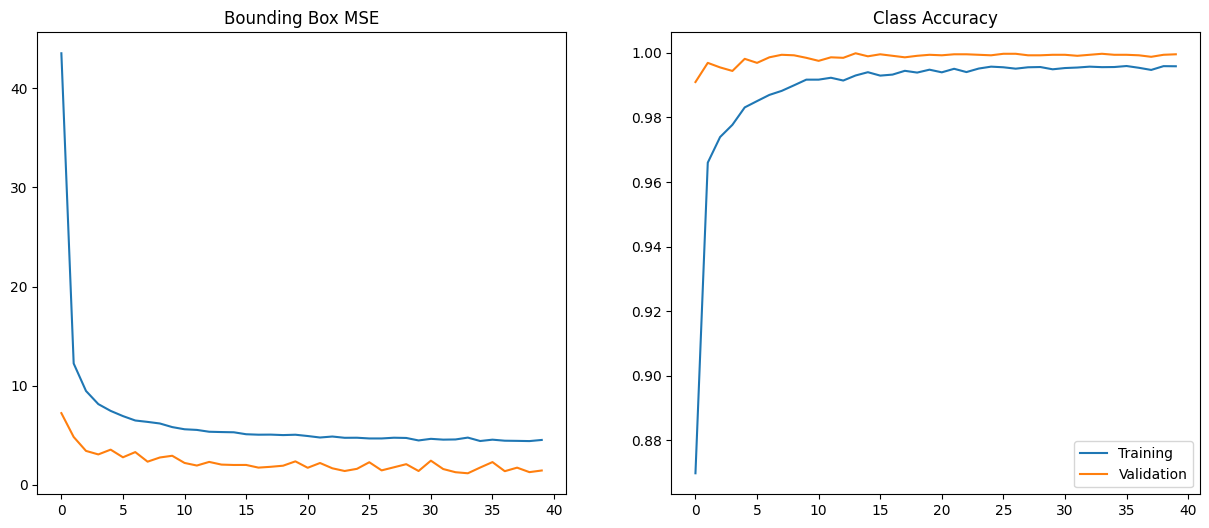

In [507]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(np.arange(epochs), localization_model_history['box_mse'], label='Training')
plt.plot(np.arange(epochs), localization_model_history['val_box_mse'], label='Validation')
plt.title('Bounding Box MSE');

plt.subplot(1,2,2)
plt.plot(np.arange(epochs), localization_model_history['class_accuracy'], label='Training')
plt.plot(np.arange(epochs), localization_model_history['val_class_accuracy'], label='Validation')
plt.title('Class Accuracy'); plt.legend()

plt.show()

The MSE works well as a cost function to train the model, but it is not a great metric to evaluate how well the model can predict bounding boxes. The most common metric for this is the **intersection over union (IoU)**: the area of overlap between the predicted bounding box and the target bounding box, divided by the area of their union:

$\displaystyle IoU = \frac{Area_{overlap}}{Area_{union}}$

![](images/intersection-over-union.png)

Let’s write  naive implementation in a function that get’s two bounding boxes as input and returns the Intersection over Union. The bounding boxes have the form (x, y, w, h), with x and y being the coordinates of the top-left corner, and w and h being the width and height of the box, respectively:

In [508]:
def iou_metric(y_true, y_pred):
    # Extract the coordinates
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Intersection coordinates
    xA = tf.maximum(y_true[:, 0], y_pred[:, 0])
    yA = tf.maximum(y_true[:, 1], y_pred[:, 1])
    xB = tf.minimum(y_true[:, 0] + y_true[:, 2], y_pred[:, 0] + y_pred[:, 2])
    yB = tf.minimum(y_true[:, 1] + y_true[:, 3], y_pred[:, 1] + y_pred[:, 3])

    # Intersection area
    interArea = tf.maximum((xB - xA), 0) * tf.maximum((yB - yA), 0)

    # True and predicted box areas
    boxAArea = y_true[:, 2] * y_true[:, 3]
    boxBArea = y_pred[:, 2] * y_pred[:, 3]

    # Union area
    unionArea = boxAArea + boxBArea - interArea

    # IoU
    epsilon = 0.000001
    return interArea / (unionArea + epsilon)

Let’s compute the IoU for a few examples:

In [509]:
y_true_congruent = [[3, 4, 10, 10]]
y_pred_congruent = [[3, 4, 10, 10]]

y_true_non_overlapping = [[2, 2, 6, 6]]
y_pred_non_overlapping = [[10, 10, 5, 5]]

y_true_overlapping = [[3, 3, 7, 7]]
y_pred_overlapping = [[7, 7, 6, 6]]

# Compute IoU for congruent boxes
iou_congruent = iou_metric(y_true_congruent, y_pred_congruent)
print(f"IoU for congruent boxes: {iou_congruent.numpy()}")

# Compute IoU for non-overlapping boxes
iou_non_overlapping = iou_metric(y_true_non_overlapping, y_pred_non_overlapping)
print(f"IoU for non-overlapping boxes: {iou_non_overlapping.numpy()}")

# Compute IoU for overlapping boxes
iou_overlapping = iou_metric(y_true_overlapping, y_pred_overlapping)
print(f"IoU for overlapping boxes: {iou_overlapping.numpy()}")

IoU for congruent boxes: [1.]
IoU for non-overlapping boxes: [0.]
IoU for overlapping boxes: [0.11842106]


Now we can evaluate the model on unseen test data using also the IoU metric:

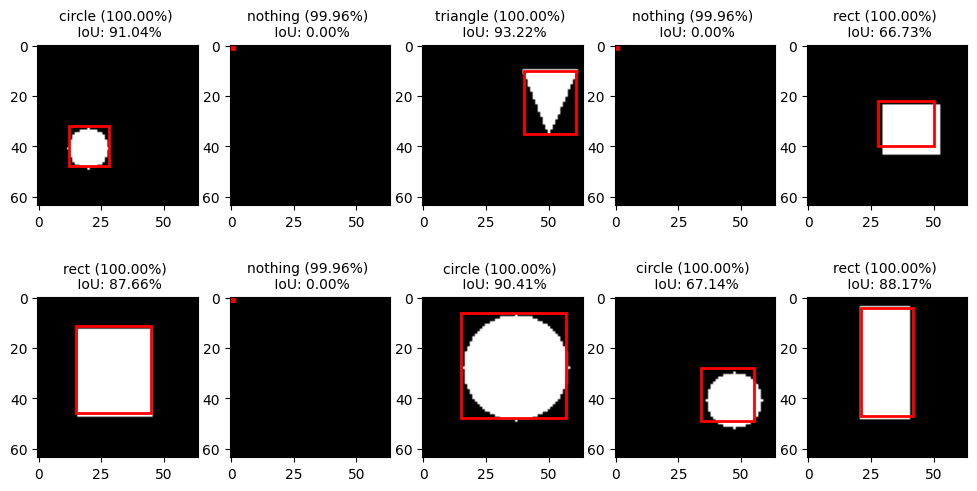

In [510]:
import matplotlib.patches as patches

pred_classes, pred_bounding_boxes = localization_model.predict(X_test[:10], verbose=0)

plt.figure(figsize=(12, 6))

for i in range(10):
    iou = iou_metric([pred_bounding_boxes[i]], [Y_test_split[1][i]])*100
    confidence = np.max(pred_classes[i])*100
    label = onehot2label(pred_classes[i])

    ax = plt.subplot(2, 5, i+1)
    ax.imshow(X_test[i], "gray")
    rect_pred = patches.Rectangle((int(pred_bounding_boxes[i, 0]), int(pred_bounding_boxes[i, 1])),
                                  int(pred_bounding_boxes[i, 2])+1, int(pred_bounding_boxes[i, 3])+1,
                                  linewidth=2, edgecolor="r", facecolor='none')
    ax.add_patch(rect_pred)

    plt.title("%s (%.2f%%) \n IoU: %.2f%%" % (label, confidence, iou), fontsize=10)

plt.show()


Classifying and localizing a single object is nice, but what if the images contain multiple objects, as is often the case? 

### Sliding Windows CNN

A simple approach is to take a CNN trained to classify and locate a single object roughly centered in the image, then **slide** the CNN across the image and make a new prediction at each step, considering detection only when the model is confident enough. For this reason the CNN is trained to predict not only class probabilities and a bounding boxes, but also an **objectness score**: the estimated probability that the image does indeed contain an object centered near the middle. It can be produced by a dense output head with a single unit, using the softmax activation function and trained using MSE loss between the position of the predicted bouding box and the center of the image:

![](images/sliding-cnn.png)

In [520]:
inputs = tf.keras.layers.Input(shape=(image_size, image_size, 1))
x = tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation="relu")(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation="relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
class_out = tf.keras.layers.Dense(object_types, activation="softmax", name="class")(x)
box_out = tf.keras.layers.Dense(4, name="box")(x)
objectness_out = tf.keras.layers.Dense(1, activation="sigmoid", name="objectness")(x)

detection_model = tf.keras.Model(inputs=inputs, outputs=(class_out, box_out, objectness_out))

In [521]:
detection_model.compile(optimizer="adam", 
                        loss={'class': 'categorical_crossentropy', 'box': 'mse', 'objectness': 'mse'},
                        metrics={'class': 'accuracy', 'box': 'mse', 'objectness': 'mse'})

For the third head of the network, we need to add to the traing set the information about the normalized distance of the object respect to the image center as a measure of objectness, more the object is centered, more the objectness score is close to 1:

In [522]:
def calculate_objectness(Y_train, image_size):
    # centers of the objects
    centers = np.zeros((Y_train.shape[0], 2))  
    centers[:, 0] = Y_train[:, 3] + Y_train[:, 5] / 2  # cx = x + width / 2
    centers[:, 1] = Y_train[:, 4] + Y_train[:, 6] / 2  # cy = y + height / 2
    
    # center of the image
    img_center = np.array([image_size / 2, image_size / 2]) 
    
    # distance from the center of each object
    #distances = np.linalg.norm(centers - img_center, axis=1)
    distances = np.sqrt((centers[:,0] - img_center[0])**2 + (centers[:,1] - img_center[1])**2)
    
    # normalization of the distance 
    #max_distance = np.sqrt(2) * (image_size / 2)
    max_distance = np.sqrt((image_size / 2)**2 + (image_size / 2)**2)

    normalized_distances = distances / max_distance
    objectness_score = 1 - normalized_distances
    
    return objectness_score

In [523]:
Y_train_split = (Y_train[:, :4], Y_train[:, 4:], calculate_objectness(Y_train, image_size))
Y_val_split = (Y_val[:, :4], Y_val[:, 4:], calculate_objectness(Y_val, image_size))
Y_test_split = (Y_test[:, :4], Y_test[:, 4:], calculate_objectness(Y_test, image_size))

We train the model with the new head:

In [524]:
import os

exists = os.path.exists("models/detection_model.keras")

if(not exists): 
    
    logdir = os.path.join("models/logs/detection_model")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    results = detection_model.fit(X_train, Y_train_split,
                                     epochs=epochs, verbose=0,
                                     validation_data=(X_val, Y_val_split),
                                     callbacks=[tensorboard_callback])

    detection_model_history = results.history
    np.save('models/detection_model', detection_model_history)
    detection_model.save('models/detection_model.keras')
else:
    detection_model = tf.keras.models.load_model("models/detection_model.keras")   
    detection_model_history = np.load('models/detection_model.npy', allow_pickle='TRUE').item() 

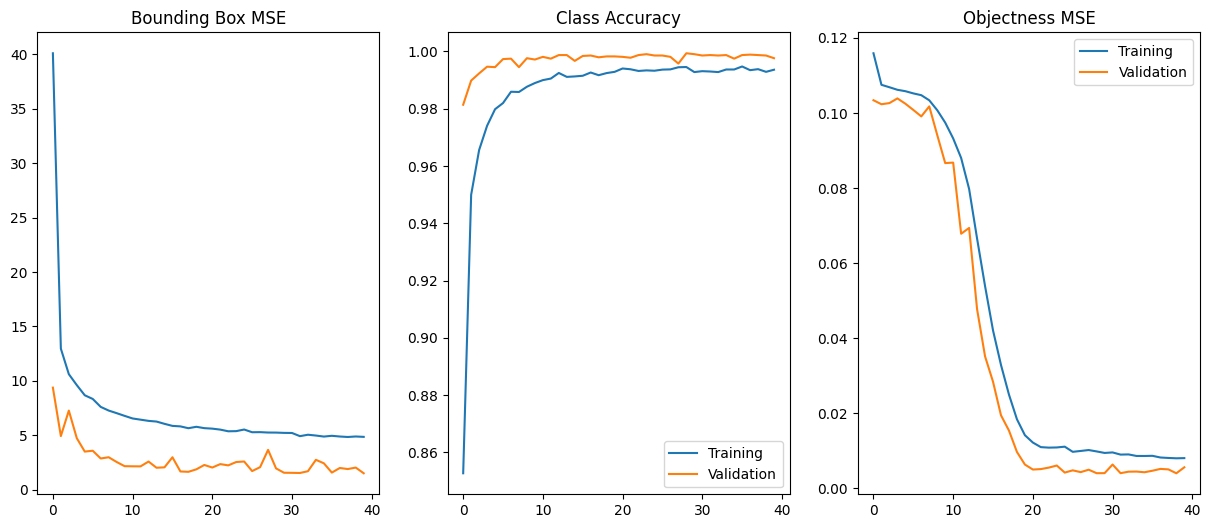

In [525]:
plt.figure(figsize=(15,6))

plt.subplot(1,3,1)
plt.plot(np.arange(epochs), detection_model_history['box_mse'], label='Training')
plt.plot(np.arange(epochs), detection_model_history['val_box_mse'], label='Validation')
plt.title('Bounding Box MSE');

plt.subplot(1,3,2)
plt.plot(np.arange(epochs), detection_model_history['class_accuracy'], label='Training')
plt.plot(np.arange(epochs), detection_model_history['val_class_accuracy'], label='Validation')
plt.title('Class Accuracy'); plt.legend()

plt.subplot(1,3,3)
plt.plot(np.arange(epochs), detection_model_history['objectness_mse'], label='Training')
plt.plot(np.arange(epochs), detection_model_history['val_objectness_mse'], label='Validation')
plt.title('Objectness MSE'); plt.legend()

plt.show()

We can now write the sliding windows function and detect objects in an image using the three heads of the network:

In [526]:
def sliding_window(image, model, step_size=10, window_size=(64, 64), objectness_threshold=0.8):
    boxes = []
    img_height, img_width = image.shape[:2]
    
    for y in range(0, img_height - window_size[1] + 1, step_size):
        for x in range(0, img_width - window_size[0] + 1, step_size):
            window = image[y:y + window_size[1], x:x + window_size[0]]
            window = np.expand_dims(window, axis=[0, -1])
            prediction = model.predict(window, verbose=0)
            class_probabilities = prediction[0]
            box_prediction = prediction[1][0]
            objectness = prediction[2]
            if objectness >= objectness_threshold:
                boxes.append((class_probabilities,
                              x + box_prediction[0], 
                              y + box_prediction[1], 
                              box_prediction[2], box_prediction[3], 
                              np.argmax(class_probabilities), objectness))       
    return boxes

To test the idea, we create a big black image with several shapes in order to apply the sliding window technique:

In [536]:
def create_multiple_objects_image(img_size, min_size, max_size, num_objects):
   
    image = np.zeros((img_size, img_size), dtype=np.uint8)

    for _ in range(num_objects):
        shape_type = random.choice(['circle', 'rectangle', 'triangle'])
        if shape_type == 'circle':
            add_circle(image, min_size, max_size)
        elif shape_type == 'rectangle':
            add_rectangle(image, min_size, max_size)
        elif shape_type == 'triangle':
            add_triangle(image, min_size, max_size)
    return image

In [545]:
image = create_multiple_objects_image(512, 10, 40, 6)

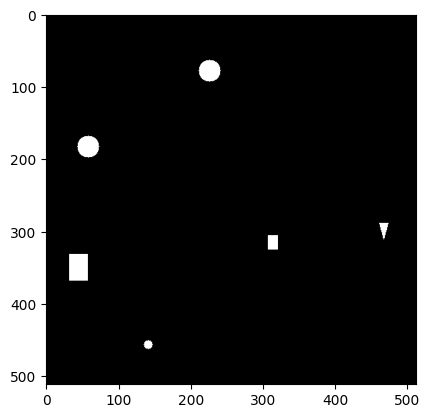

In [546]:
plt.imshow(image, "gray")
plt.show()

In [553]:
detected_predictions = sliding_window(image, detection_model, step_size=16, window_size=(64, 64), objectness_threshold=0.6)

We can show the bounding boxes detected by the model:

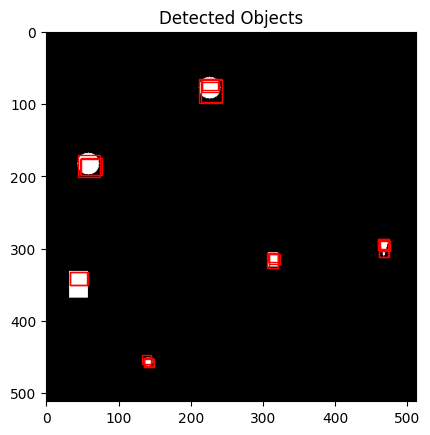

In [554]:
plt.imshow(image, cmap='gray')
for box in detected_predictions:
    rect = plt.Rectangle((box[1], box[2]), box[3], box[4], linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
plt.title('Detected Objects')
plt.show()

This technique is straightforward, but it will **often detect the same object multiple times, at slightly different positions**. Some postprocessing is needed to get rid of all the unnecessary bounding boxes. A common approach for this is called **non-max suppression**: we sort the bounding boxes by objectness score and starting from the top for each bounding box, we get rid of all the other bounding boxes that have a high IoU with it. This way, only the highest-scoring bounding box is kept for each object. This is repeated until there are no more bounding boxes to get rid of:

In [555]:
def non_max_suppression(boxes, iou_threshold):
    if len(boxes) == 0:
        return []
    
    boxes = sorted(boxes, key=lambda x: x[5], reverse=True)
    filtered_boxes = []
    
    while boxes:
        best_box = boxes.pop(0)
        filtered_boxes.append(best_box)
        boxes = [box for box in boxes if iou_metric([best_box[1:5]], [box[1:5]]) < iou_threshold]
        
    return filtered_boxes

In [556]:
filtered_predictions = non_max_suppression(detected_predictions, iou_threshold=0.05)

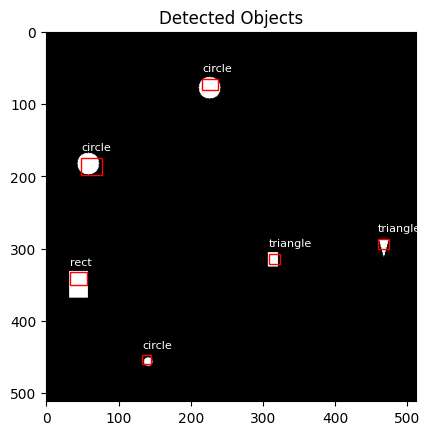

In [574]:
plt.imshow(image, cmap='gray')
for box in filtered_predictions:
    rect = plt.Rectangle((box[1], box[2]), box[3], box[4], linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    plt.text(box[1], box[2] - 10, onehot2label(box[0]), color='white', fontsize=8)
plt.title('Detected Objects')
plt.show()

Now, we have seed how sliding the CNN across the whole image would give us several predicted bounding boxes, organized in the grid, with each box accompanied by its predicted class. However, in general  objects can have **varying sizes**, so we may be temted to slide the CNN again across larger regions as well, to get even more bounding boxes:

![](images/sliding-window-size.png)

This simple approach works pretty well, however it requires running the CNN many times, so it is quite slow.

### You Only Look Once (YOLO)

In order to speedup the process, we can reframe the object detection as **a single regression problem** instead of a classification problem. In this way, the algorithm **only looks at the image once** to detect what objects are present and where they are. YOLO was first introduced in 2015 in the research paper [“You Only Look Once: Unified, Real-Time Object Detection”](https://arxiv.org/abs/1506.02640). Instead of sliding a window, the input image is divided into an SxS grid of cells. For each object that is present on the image, one grid cell is said to be "responsible" for prediction if the center of the object falls into it. Each grid cell predicts B bounding boxes and C class probabilities. The bounding box prediction has five components: (x, y, w, h, confidence). The (x, y) coordinates represent the center of the box, relative to the grid cell location. These coordinates are normalized to fall between 0 and 1. The (w, h) box dimensions are also normalized to [0, 1], relative to the image size. Let’s look at an example of a box coordinates in a 448x448 image with S=3:

![](images/yolo-x-y-w-h.png)

The confidence score of each bounding box prediction is defined as 

$\displaystyle Pr(Object) * IOU(pred, truth)$ 

If no object exists in the cell, the confidence score should be zero, otherwise it is equal to the intersection-over-union between the predicted box and the ground truth. Notice that the confidence reflects the presence or absence of an object of any class. Each grid cell makes B of those predictions, so there are in total SxSxB*5 outputs related to bounding box predictions.

It is also necessary to predict the class probabilities:

$\displaystyle Pr(Class(i) | Object)$

This probability is conditioned on the grid cell containing one object. It means that if no object is present on the grid cell, the loss function will not penalize it for a wrong class prediction. The network only predicts one set of class probabilities per cell, regardless of the number of boxes B. That makes SxSxC class probabilities in total. Adding the class predictions to the output vector, we get 

$\displaystyle S * S * (B * 5 + C)$ 

tensor as output. As an example, considering S=3, B=2 and C=3 we have_

![](images/yolo-predictions.png)

The YOLO network structure looks like a normal CNN, with convolutional and max pooling layers, followed by two fully connected layers in the end. In particular, the origial architecture was crafted for use in the Pascal VOC dataset, and the authors used S=7 (cells), B=2 (bounding boxes) and C=20 (classes):

![](images/yolo.png)

The loss function is constructed summing over each bounding box predictor (j = 0...B) of each grid cell (i = 0...S^2), however the contribution is considered only if an object is present in the grid cell i and the bounding box j is "responsible" for that prediction:

$\displaystyle \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{1}_{ij}^{obj} \left[ (x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2 \right]$

We add a loss term related to the predicted box width and height. The equation looks similar to the first one, except for the use of the square root. The error metric reflects that small deviations in large boxes matter less than in small boxes:

$\displaystyle \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{1}_{ij}^{obj} \left[ (\sqrt{w_i} - \sqrt{\hat{w}_i})^2 + (\sqrt{h_i} - \sqrt{\hat{h}_i})^2 \right]$

Then, we have a loss term associated with the confidence score for each bounding box predictor. $C$ is the confidence score and $\hat{C}$ is the intersection-over-union of the predicted bounding box with the ground truth:

$\displaystyle \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{1}_{ij}^{obj} (C_i - \hat{C}_i)^2 + \lambda_{noobj} \sum_{i=0}^{S^2} \sum_{j=0}^{B} \mathbb{1}_{ij}^{noobj} (C_i - \hat{C}_i)^2$

The parameters is used to differently weight the two parts of the loss functions. Fianlly, the last part of the loss function is the classification loss. It looks similar to a normal sum-squared error for classification, except we don’t penalize classification error when no object is present on the cell:

$\displaystyle \sum_{i=0}^{S^2} \mathbb{1}_{i}^{obj} \sum_{c \in classes} (p_i(c) - \hat{p}_i(c))^2$

YOLO was continuously improved over the years, with YOLOv2, YOLOv3, YOLO9000, YOLOv5, PP-YOLO, etc. by different researchers. Each version brought some impressive improvements in speed and accuracy, using a variety of techniques. For example, the accuracy was improved exploiting the fact that some bounding box shapes are more likely than others, depending on the class (e.g. people tend to have vertical bounding boxes, while cars usually don’t).

We can explore how to use YOLO and a webcam to get started with a real-time object detection system. YOLO has been implemented in several deep learning frameworks, including TensorFlow, and PyTorch. However, we exploit the [ultralytics library](https://github.com/ultralytics) that makes working with YOLO very easy. In order to capture images from the webcam we exploit the [OpenCV library](https://opencv.org/).  First of all, we create a VideoCapture object and set it to capture frames from the default camera:

In [1]:
import cv2

cap = cv2.VideoCapture(0)
cap.set(3, 640)
cap.set(4, 480)

2024-07-05 09:16:51.623 python[3257:167171] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


True

Then we can show a stream of frames from the camera:

In [2]:
import opencv_jupyter_ui as jcv2
jcv2.setKeys([])

while True:
    _, frame = cap.read()
    jcv2.imshow('webcam', frame)
    if jcv2.waitKey(10)=='q':
        break

Exection is stopped


We load the YOLO model using the ultralytics library and specifies the location of the YOLO weights from the v8 version:

In [3]:
from ultralytics import YOLO
yolo = YOLO("models/yolov8n.pt")

We instantiate a classNames variable containing a list of object classes that the YOLO model is trained to detect.

In [4]:
classNames = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat",
              "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
              "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
              "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
              "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup",
              "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli",
              "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed",
              "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone",
              "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
              "teddy bear", "hair drier", "toothbrush"
              ]

Now we modify the while loop passing the frame to the YOLO model for object detection. For each detected object, we extract the bounding box coordinates ìand draws a rectangle around it using cv2.rectangle(). We also prints the confidence score and class name of the detected object on the console.

In [5]:
import math 

while True:
    _, frame = cap.read()
    results = yolo(frame, stream=True, verbose=False)
    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0]
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 255), 3)
            cv2.putText(frame, classNames[int(box.cls[0])], [x1, y1], 
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1,
                        color=(255,0,0), thickness=1)

    jcv2.imshow('yolo', frame)
    if jcv2.waitKey(1)=='q':
       break

Exection is stopped


We’ve only considered detecting objects in single images. But what about videos? Objects must not only be detected in each frame, they must also be **tracked over time**. Object tracking is a challenging task: objects move, they may grow or shrink as they get closer to or further away from the camera, their appearance may change as they turn around or move to different lighting conditions or backgrounds, they may be temporarily occluded by other objects, and so on. One of the most popular object tracking systems is [**DeepSORT**](https://arxiv.org/abs/1703.07402).⁠ It is based on a combination of classical algorithms and deep learning:

- it uses Kalman filters to estimate the **most likely current position** of a object given prior detections, and assuming that objects tend to move at a constant speed;

- it uses a deep learning model to measure the **resemblance between new detections and existing tracked objects**

- lastly, it uses the Hungarian algorithm to **map new detections to existing tracked objects** (or to new tracked objects)


## Semantic Segmentation

So far we have located objects using bounding boxes. This is often sufficient, but sometimes you need to locate objects with much **more precision**, for example  to remove the background behind a person during a videoconference call. We can **classify each pixel** according to the class of the object it belongs to (e.g. road, car, pedestrian, building, etc.):

![](images/semantic-segmentation.png)

There are several applications for which semantic segmentation is very useful. Automated segmentation of body scans can help doctors to perform diagnostic tests. Autonomous vehicles can detect drivable regions, aerial images can be used to segment different types of land or medial images can be segmented to preform diagnostic tests.

As usual, the first step in training a segmentation model is to prepare the dataset. We would need the input images and the corresponding segmentation images. If we want to make our own dataset, a tool like [labelme](https://github.com/labelmeai/labelme) can be used to manually generate the ground truth segmentation masks. In the segmentation images, the pixel value should denote the class ID of the corresponding pixel. This is a common format used by most of the datasets. Notice that, for the segmentation maps we canot use the JPG format as it is lossy and the pixel values might change. We need to use BMP or PNG format instead. And of course, the size of the input image and the segmentation image should be the same.

As an example, we can uses the [**Oxford-IIIT Pet Dataset**](https://www.robots.ox.ac.uk/%7Evgg/data/pets/), which consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories:

- Class 1: Pixel belonging to the pet
- Class 2: Pixel bordering the pet
- Class 3: None of the above/a surrounding pixel

The dataset is available from TensorFlow Datasets:

In [1]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

We normalize the image color values to the [0, 1] range and for convenience we subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}

In [2]:
import tensorflow as tf
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [3]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128),
                               method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

The dataset already contains the required training and test splits, so continue to use the same splits:

In [4]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

As usual, if we have a small number of training pairs, the results might not be good because the model might overfit. We can increase the size of the dataset by applying random transformations on the images. We can change the color properties like hue, saturation, brightness of the input images. We can also apply transformations such as rotation, scale, and flipping. For the transformations which change the location of the pixels, the segmentation image should also be transformed the same way. The following class performs a simple augmentation by randomly-flipping images:

In [6]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

We build the input pipeline, applying the augmentation after batching the inputs:

In [7]:
batch_size = 64
buffer_size = 1000

train_batches = (
    train_images
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(batch_size)

We can visualize an image example and its corresponding mask from the dataset:

In [8]:
import matplotlib.pyplot as plt

image, mask = train_batches.take(2)
sample_image, sample_mask = images[0], masks[0]

plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)
plt.title('Input Image')
plt.imshow(tf.keras.utils.array_to_img(sample_image))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Mask')
plt.imshow(tf.keras.utils.array_to_img(sample_mask))
plt.axis('off')

plt.show()

### U-Net

The main difficulty in this task is that when images go through a regular CNN, they gradually lose their spatial resolution (due to the layers with strides greater than 1) and at the end fully connected layers destroy all the spatial information. So it ends up knowing that there’s a cat somewhere in the center of the image, but it will not be much more precise than that. For semantic segmentation, we need to **retain the spatial information**. To do that we add more convolution layers coupled with **upsampling layers** which increase the size of the spatial tensor. As we increase the resolution, we decrease the number of channels as we are getting back to the low-level information. This is called an **encoder-decoder structure**. Where the layers which downsample the input are the part of the encoder and the layers which upsample are part of the decoder:

![](images/encoder-decoder.png)

There are several solutions available for upsampling, such as bilinear interpolation, but that only works reasonably well up to x4 or x8. Another possibility is to use the **transposed convolutional layer**.⁠ It is equivalent to first stretching the image by inserting empty rows and columns (full of zeros), then performing a regular convolution. The transposed convolutional layer can be initialized to perform something close to linear interpolation, but since it is a trainable layer, it will learn to do better during training.

![](images/upsampling.png)

When the model is trained, the encoder outputs a tensor containing information about objects, their shapes and sizes. The decoder takes this information and produces the segmentation map. However, if we simply stack the encoder and decoder layers, there could be loss of low-level  information and the boundaries produced could be inaccurate. To make up for the information lost, we let the decoder to access low-level features produced by the encoder layers. That is accomplished by the idea of **skip connections** already used in ResNet: intermediate outputs of the encoder are added/concatenated with the inputs to the intermediate layers of the decoder at appropriate positions:

![](images/encoder-decoder-skip-connections.png)

The skip connections from the earlier layers provide the necessary information to the decoder layers which is required for creating accurate boundaries. This approach is called [**U-Net**](https://arxiv.org/abs/1505.04597)

The models trained for image classification (e.g. ResNet, MobileNet) contain meaningful information which can be used for segmentation as well. We can re-use the convolution layers of the pre-trained models in the encoder layers of the segmentation model (transfer learning):

![](images/semantic-segmentation-transfer-learning.png)

About the loss function, since each pixel of the output of the network is compared with the corresponding pixel in the ground truth segmentation image, we can apply standard cross-entropy loss on each pixel.

As an example, we can use a pretrained MobileNetV2 model as the encoder:

In [25]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

encoder = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
encoder.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


The decoder/upsampler is simply a series of upsample blocks implemented using the transposed convolutional layer of Keras:

In [33]:
# 4x4 -> 8x8
decoder_layer_1 = tf.keras.Sequential()
decoder_layer_1.add(tf.keras.layers.Conv2DTranspose(filters=512, kernel_size=3, strides=2, padding='same', use_bias=False))
decoder_layer_1.add(tf.keras.layers.BatchNormalization())
decoder_layer_1.add(tf.keras.layers.ReLU())

# 8x8 -> 16x16
decoder_layer_2 = tf.keras.Sequential()
decoder_layer_2.add(tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, padding='same', use_bias=False))
decoder_layer_2.add(tf.keras.layers.BatchNormalization())
decoder_layer_2.add(tf.keras.layers.ReLU())

# 16x16 -> 32x32
decoder_layer_3 = tf.keras.Sequential()
decoder_layer_3.add(tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', use_bias=False))
decoder_layer_3.add(tf.keras.layers.BatchNormalization())
decoder_layer_3.add(tf.keras.layers.ReLU())

# 32x32 -> 64x64
decoder_layer_4 = tf.keras.Sequential()
decoder_layer_4.add(tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', use_bias=False))
decoder_layer_4.add(tf.keras.layers.BatchNormalization())
decoder_layer_4.add(tf.keras.layers.ReLU())

decoder_stack = [
    decoder_layer_1,
    decoder_layer_2,
    decoder_layer_3,
    decoder_layer_4
]

We can compose the finel model connecting encoder, decoder and adding skip connections. Note that the number of filters on the last layer is set to the number of output_channels. This will be one output channel per class.

In [34]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  skips = encoder(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  for up, skip in zip(decoder_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  #64x64 -> 128x128
  last = tf.keras.layers.Conv2DTranspose(filters=output_channels, kernel_size=3, strides=2, padding='same') 
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [36]:
unet = unet_model(output_channels=3)

unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

We can create a funtion to show the predictions of the model and use it to see how the model performs before and after training:

In [39]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [40]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


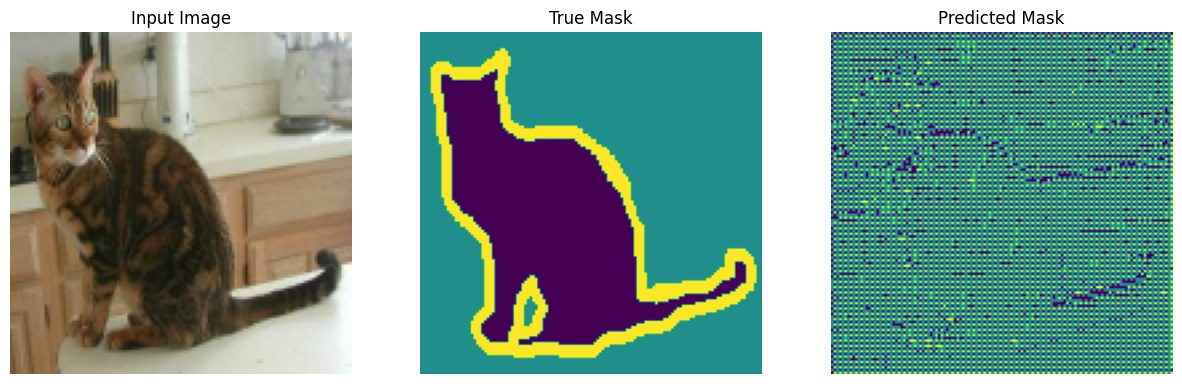

In [41]:
show_predictions()

In [ ]:
val_subsplits = 5
batch_size = 64
validation_steps = info.splits['test'].num_examples//batch_size//val_subsplits
train_length = info.splits['train'].num_examples
steps_per_epoch = train_length // batch_size

path.exists("models/unet_model.keras")

if(not exists):
    logdir = os.path.join("models/logs/unet_model")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    result = unet.fit(train_batches, epochs=epochs,
                          steps_per_epoch=steps_per_epoch,
                          validation_steps=validation_steps,
                          validation_data=test_batches,
                        callbacks=[tensorboard_callback])
    unet_history = result.history
    np.save('models/unet_model', unet_history)
    unet.save('models/unet_model.keras')
else:
    unet = tf.keras.models.load_model("models/unet_model.keras")   
    unet_history = np.load('models/unet_model.npy', allow_pickle='TRUE').item() 


We can show the training and validation loss graphs:

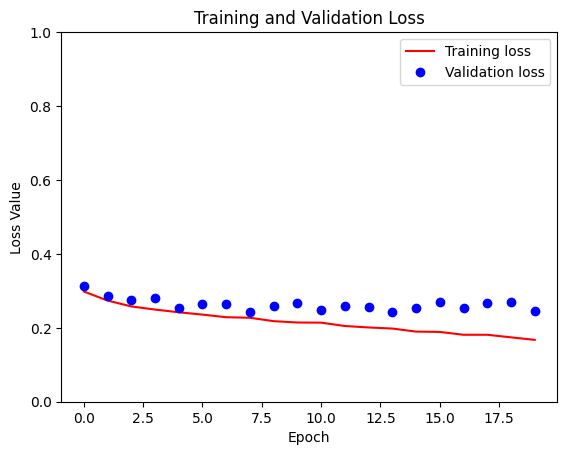

In [54]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

Finally, the prediction of the model on the test set can be visualized:

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step


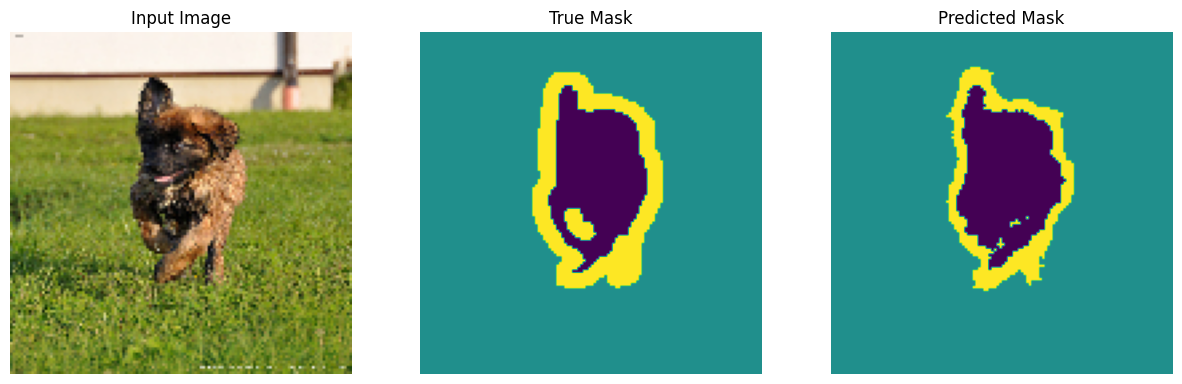

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


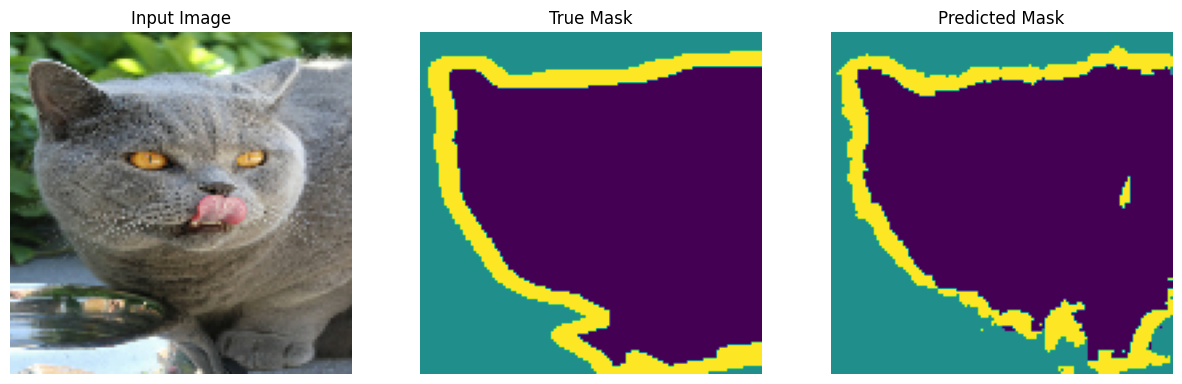

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


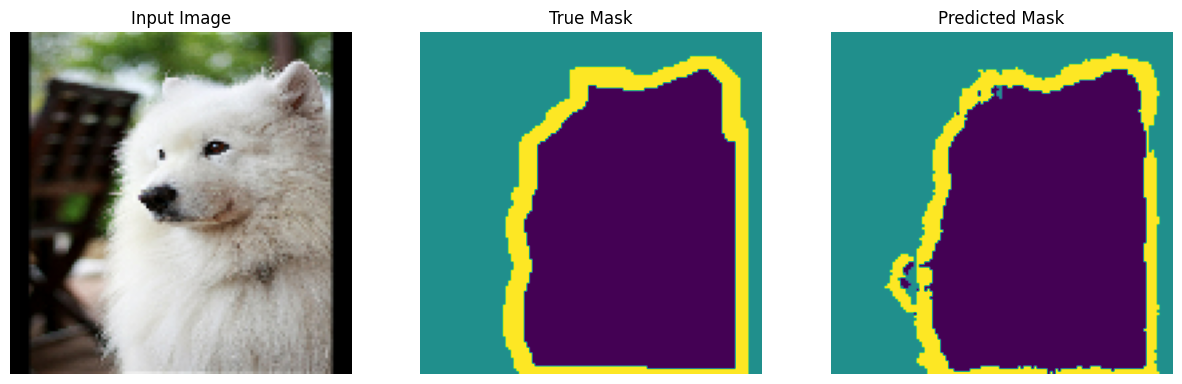

2024-07-04 17:27:17.210365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [55]:
show_predictions(test_batches, 3)

Instance segmentation is similar to semantic segmentation, but instead of merging all objects of the same class into one big lump, each object is distinguished from the others (e.g., it identifies each individual bicycle). For example the Mask R-CNN architecture, proposed in a 2017 paper⁠ by
Kaiming He et al., extends the Faster R-CNN model by additionally producing a pixel mask for each bounding box. So, not only do you get a bounding box around each object, with a set of estimated class probabilities, but you also get a pixel mask that locates pixels in the bounding box that
belong to the object. This model is available on TensorFlow Hub, pretrained on the COCO 2017 dataset. The field is moving fast, though so if you want to try the latest and greatest models, please check out the state-of-the-art section of https://paperswithcode.com

As you can see, the field of deep computer vision is vast and fast-paced, with all sorts of architectures popping up every year. Almost all of them are based on convolutional neural networks, but since 2020 another neural net architecture has entered the computer vision space: **transformers**. The progress made over the last decade has been astounding, and researchers are now focusing on harder and harder problems, such as **adversarial learning** (which attempts to make the
network more resistant to images designed to fool it), **explainability** (understanding why the network makes a specific classification), **realistic image generation**, **single-shot learning** (a system that can recognize an object after it has seen it just once), **predicting the next frames in a video**, **combining text and image tasks**, and more.

## Exercise

**Implement from scratch the runner-up in the ILSVRC 2014 challenge, the [VGGNet](https://arxiv.org/abs/1409.1556) on CIFAR-100. It is a very simple and classical architecture: it had 3 convolutional layers and a pooling layers, then again 3 convolutional layers and a pooling layer, and so on (reaching a total of 19 convolutional layers), plus a final dense network with 2 hidden layers and the output layer. It used small 3 × 3 filters, but it had many of them.**

https://mrgrhn.medium.com/vggnet-with-tensorflow-transfer-learning-with-vgg16-included-7e5f6fa9479a
